# 5.  Modeling 
##  (3) <span style = 'color:darkcyan'>머신러닝 모델(XGB, LGBM)</span>을 사용하여 6,7,8월 음식물 쓰레기 예측

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc 
%matplotlib inline
rc('font', family='malgun gothic')
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score , silhouette_samples

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats.mstats import gmean, hmean

#json
from bs4 import BeautifulSoup
import urllib.request as ul
import time
import xmltodict
import json
import sys
import io

import xml.etree.ElementTree as ET
import xmltodict
import json
import datetime

## 예측용 피쳐셋 생성

**시간적 데이터**: 각 행에 해당하는 월, 요일, 날짜 등 시간적인 데이터를 추가한다 \
		-> 시계열적인 특성을 살리기 위함

**전년도 데이터**: 셀렉팅된 피쳐셋의 1년 전 데이터를 새로운 피쳐로 활용 \
		-> 1년 전 데이터를 통해 특정일에 대한 과적합을 방지하고 일반화하기 위함
 
**함수의 파라미터 two**: 7월 예측, 8월 예측에 따라 필요한 target데이터를 처리해준다 \
 		-> 7월예측은 한달전 데이터로, 8월예측은 두달전 데이터가 필요하기 때문이다.

In [4]:
def create_features(df, two,label=None):
    """
    Creates time series features from datetime index
    """
    
    d=[str(i).split(' ')[0] for i in pd.date_range('2021-07-01','2021-08-31',freq='D')]
    do=list(df['emd_nm_jh'].unique())
    da=d*len(do)
    don=[]
    for i in df['emd_nm_jh'].unique():
        don.extend(((i+',')*62).split(',')[:-1])
    tt=pd.DataFrame({'base_date_jh':da,'emd_nm_jh':don})

    df=pd.merge(tt,df, on=['base_date_jh','emd_nm_jh'],how='outer')
    df=df.sort_values(by=['emd_nm_jh','base_date_jh']).reset_index(drop=True)
    df_date=list(df['base_date_jh'])
    df_date.extend(d)
    df['base_date_jh']
    df['date']=pd.to_datetime(df['base_date_jh'])
    df['dayofweek'] = df['date'].dt.dayofweek #요일
    df['quarter'] = df['date'].dt.quarter #쿼터
    df['month'] = df['date'].dt.month #달
    df['year'] = df['date'].dt.year #년도
    df['dayofyear'] = df['date'].dt.dayofyear #년도의 몇번째 날인지
    df['dayofmonth'] = df['date'].dt.day #일
    df['weekofyear'] = df['date'].dt.weekofyear #년도의 몇번쨰 주인지
    #df['em_g_diff1'] = df['em_g_jh'].shift(31)
    yearfeature=df.iloc[:,2:].shift(365) #전년도 피쳐
    yearfeature.columns=['year_'+i for i in df.iloc[:,2:].columns]
    
    if two==0:
        df.iloc[:,3:] = df.iloc[:,3:].shift(31) #7월 예측에 필요
    else: 
        df.iloc[:,3:] = df.iloc[:,3:].shift(62) #8월 예측에 필요

    df['shif']=df['em_g_jh'].shift(365) #1년 전의 y값
    df['target']=df['em_g_jh']-df['shif'] #현재값과 1년전의 차이
    df=pd.concat([df,yearfeature],axis=1)
    df=df.query('base_date_jh>"2018-12-31"')
    
    dong=pd.get_dummies(df['emd_nm_jh'])
    df=pd.concat([df,dong],axis=1)
   # df=df.query('base_date>"2018-12-31"')
    #df=df.drop(['base_date','date','emd_nm'],axis=1)
    
    
    X = df
    
    if label:
        y = df[label]
        return X, y
    else:
        return X


### 데이터셋 스플릿

In [5]:
featureset0=pd.read_csv('features/군집0_feature_corona.csv')
featureset0=featureset0.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

<AxesSubplot:>

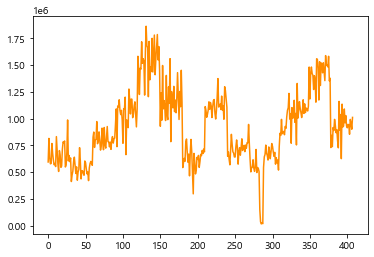

In [6]:
featureset0.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color='darkorange')

<AxesSubplot:>

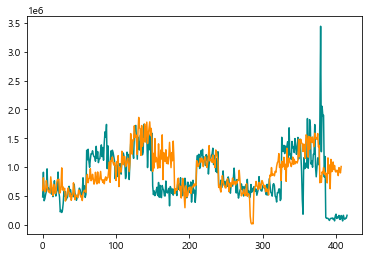

In [7]:
featureset0.query('base_date_jh>="2020-06-01" & base_date_jh<="2020-06-30"')['em_g_jh'].reset_index(drop=True).plot(color='darkcyan')
featureset0.query('base_date_jh>="2021-06-01"')['em_g_jh'].reset_index(drop=True).plot(color='darkorange')

- 2021년 6월의 데이터를 Testset으로 하고 나머지의 데이터들을 Trainset으로 나누어 학습을 진행한다
- train_test1함수는 차이예측을 목적으로 하기 때문에 추후에 y_plus변수의 1년전의 데이터를 더해준다. 최종 예측결과물은 (예측값+y_plus)이다.
- train_test2함수는 직접적인 예측을 목적으로 하기 때문에 trainset과 testset으로의 분할만 진행한다.
- 최종 결과물을 위해 2021년 7월의 july, 2021년 8월의 august 데이터셋을 생성한다.

In [8]:
def train_test1 (X,y):
    X_train = X.query('base_date_jh<"2021-06-01"')
    X_test = X.query('base_date_jh>="2021-06-01" & base_date_jh<="2021-06-30"')
    july = X.query('base_date_jh>="2021-07-01" & base_date_jh<="2021-07-31"')
    august = X.query('base_date_jh>="2021-08-01" & base_date_jh<="2021-08-31"')
    #X_train.set_index(X_train['date'],inplace=True)
    #X_test.set_index(X_test['date'],inplace=True)
    
    mean_data=X_train.groupby('emd_nm_jh')['target'].mean()
    y_train=[]
    y_test=[]
    y_plus=[]
    july_plus=[]
    august_plus=[]
    for i in X_train['emd_nm_jh'].unique():
        yyy=X_train.query('emd_nm_jh==@i')['target']#예측할 차이값
        yyyy=X_test.query('emd_nm_jh==@i')['target']
        jjj=july.query('emd_nm_jh==@i')['target']
        aug=august.query('emd_nm_jh==@i')['target']
        plus=X_test.query('emd_nm_jh==@i')['shif']#차이값에 더해줄 작년값
        j_plus=july.query('emd_nm_jh==@i')['shif']
        a_plus=august.query('emd_nm_jh==@i')['shif']
        y_train.extend(yyy)
        y_test.extend(yyyy)
        y_plus.extend(plus)
        july_plus.extend(j_plus)
        august_plus.extend(a_plus)
    
    y_train=pd.Series(y_train)
    y_test = pd.Series(y_test) #예측할 차이값
    y_plus = pd.Series(y_plus) #차이값에 더해줄 작년값
    july_plus = pd.Series(july_plus)
    august_plus = pd.Series(august_plus)
    #y_train.index=X_train['date']
    #y_test.index=X_test['date']
    
    X_train=X_train.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','target','shif'],axis=1)
    X_test=X_test.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','target','shif'],axis=1)
    july=july.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    august=august.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    X=X.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','target','shif'],axis=1)

    return X,X_train,X_test,july,august,y_train,y_test,y_plus,july_plus,august_plus



In [9]:
def train_test2 (X,y):
    X_train = X.query('base_date_jh<"2021-06-01"')
    X_test = X.query('base_date_jh>="2021-06-01" & base_date_jh<="2021-06-30"')
    july = X.query('base_date_jh>="2021-07-01" & base_date_jh<="2021-07-31"')
    august = X.query('base_date_jh>="2021-08-01" & base_date_jh<="2021-08-31"')
    y_train=y[X_train.index]
    y_test=y[X_test.index]
    
    X_train.reset_index(drop=True)
    X_test.reset_index(drop=True)
    july.reset_index(drop=True)
    august.reset_index(drop=True)
    y_train.reset_index(drop=True)
    y_test.reset_index(drop=True)
    
    X_train=X_train.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    X_test=X_test.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    july=july.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    august=august.drop(['base_date_jh','date','emd_nm_jh','em_g_jh','year_date','shif','target'],axis=1)
    X=X.drop(['base_date_jh','date','emd_nm_jh','em_g_jh'],axis=1)
    
    return X,X_train,X_test,july,august,y_train,y_test,



# Modeling

- 본 분석에서는 XGB와 LGBM을 모델로 활용한다

## Parameter Tuning

- 효과적인 하이퍼파라미터 튜닝을 위해 Bayesian Optimizer를 활용한다
- 평가지표는 MAE를 활용한다.
- Bayesian Optimizer를 진행한 뒤에는 최고의 결과값을 같는 파라미터들을 활용하여 최종 결과값을 예측한다.

### XGB 베이지안

Tuning Parameter:
- learning_rate: 학습률
- n_estimators: 생성할 트리의 수
- max_depth: 트리의 최대 깊이, 과적합을 방지하기 위해 사용함
- subsample: 개별 의사결정나무 모형에 사용되는 임의 표본수
- gamma: 리프노드의 추가분할을 결정할 최소손실 감소값, 과적합 방지

In [11]:
BO_tuned_clfs=[]
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_log_error


xgb_pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 100),
            'max_depth': (5,15),   
            'subsample': (0.8,0.95),   
            'gamma': (0, 5)}

def xgb_opt1(learning_rate, n_estimators, max_depth, subsample, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'gamma': gamma,
        'n_jobs' : -1,
    }
    
    reg = xgb.XGBRegressor(**params)
    
    reg.fit(X1_train, y1_train,
        eval_set=[(X1_train, y1_train), (X1_test, y1_test)],
       verbose=False)
    
    pred = reg.predict(X1_test)
    
    score= 1-mean_absolute_error(y1_test, pred)
    
    return score

def xgb_opt2(learning_rate, n_estimators, max_depth, subsample, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'gamma': gamma,
        'n_jobs' : -1,
    }
    
    reg = xgb.XGBRegressor(**params)
    
    reg.fit(X2_train, y2_train,
        eval_set=[(X2_train, y2_train), (X2_test, y2_test)],
       verbose=False)
    
    pred = reg.predict(X2_test)
    
    score= 1-mean_absolute_error(y2_test, pred)
    
    return score

In [12]:
def model(x,X_train,y_train,X_test,submit_test): 
    x.maximize(init_points=50, n_iter=50)

    # BO_xgb.res  # 모든 성능 들어가있음
    x.max

    max_params1 = x.max['params']

    max_params1['n_estimators'] = int(round(max_params1['n_estimators']))
    max_params1['max_depth'] = int(round(max_params1['max_depth']))

    xgb_clf1 = xgb.XGBRegressor(**max_params1)

    xgb_clf1.fit(X_train, y_train)

    pred_xgb = xgb_clf1.predict(X_test)
    submit_xgb = xgb_clf1.predict(submit_test)
    
    return pred_xgb,submit_xgb, xgb_clf1

### LGBM 베이지안

Tuning Parameter:
- learning_rate: 학습률
- n_estimators: 생성할 트리의 수
- max_depth: 트리의 최대 깊이, 과적합을 방지하기 위해 사용함
- subsample: 개별 의사결정나무 모형에 사용되는 임의 표본수
- colsample_bytree: 트리 생성에 필요한 피쳐의 샘플링
- num_leaves: 전체 트리의 leave의 수
- min_child_weight: 관측치에 대한 과중치 합의 최솟값

In [13]:
lgbm_pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def lgbm_opt1(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgb = lgbm.LGBMRegressor(**params)
    
    lgb.fit(X1_train, y1_train,
        eval_set=[(X1_train, y1_train), (X1_test, y1_test)],
       verbose=False)
    
    pred1 = lgb.predict(X1_test)
    
    score1= -mean_absolute_error(y1_test, pred1)
    
    return np.mean(score1)


def lgbm_opt2(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves,  min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgb2 = lgbm.LGBMRegressor(**params)
    
    lgb2.fit(X2_train, y2_train,
        eval_set=[(X2_train, y2_train), (X2_test, y2_test)],
       verbose=False)
    
    pred2 = lgb2.predict(X2_test)
    
    score2= -mean_absolute_error(y2_test, pred2)
    
    return np.mean(score2)
 

In [14]:
def lgbm_model(x,X_train,y_train,X_test,submit_test): 
    x.maximize(init_points=50, n_iter=50)

    # BO_xgb.res  # 모든 성능 들어가있음
    x.max

    max_params1 = x.max['params']

    max_params1['n_estimators'] = int(round(max_params1['n_estimators']))
    max_params1['max_depth'] = int(round(max_params1['max_depth']))

    lgb_clf1 = lgbm.LGBMRegressor(**max_params1)

    lgb_clf1.fit(X_train, y_train)

    pred_lgb = lgb_clf1.predict(X_test)
    submit_lgb = lgb_clf1.predict(submit_test)
    
    return pred_lgb,submit_lgb, lgb_clf1

### 각 군집별 예측

- 2가지의 모델들로 2가지의 값을 예측한뒤 총 4개의 결과값을 Gmean을 통해 앙상블을 실시한다. \
XGB차이예측, XGB직접예측, LGBM차이예측, LGBM직접예측
- 차이예측의 결과값에 대해서는 이상치제거를 하므로써 결과값이 특정 데이터셋에 의해 특이값이 발생되지 않도록 방지한다.

## Cluster0

In [1580]:
featureset0=pd.read_csv('features/군집0_feature_corona.csv')
featureset0=featureset0.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1581]:
X,y=create_features(featureset0,0,'em_g_jh')

In [1582]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1583]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1584]:
y2_test.to_csv('predict/cl0_test.csv',index=False)

In [1585]:
# 옵티마이저 적용
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1)  

In [1587]:
#XGB 차이예측
pred_xgb0_1, july_xgb0_1, xgb_clf0_1=model(BO_xgb1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  8        | -1.809e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  9        | -1.758e+0 |  3.353    |  0.3551   |  6.289    |  65.77    |  0.8546   |
|  10       | -1.824e+0 |  2.851    |  0.686    |  14.88    |  55.1     |  0.8313   |
|  11       | -2.158e+0 |  0.8065   |  0.997    |  7.533    |  73.32    |  0.8367   |
|  12       | -1.499e+0 |  0.7948   |  0.21     |  11.56    |  56.91    |  0.8295   |
|  13       | -2.545e+0 |  1.844    |  1.24     |  5.971    |  91.9     |  0.8144   |
|  14       | -1.8e+05  |  4.882    |  0.7295   |  14.77    |  80.24    |  0.9109   |
|  15       | -1.629e+0 |  0.1959   |  0.4601   |  6.202    |  64.81    |  0.8178   |
|  16       | -1.779e+0 |  1.59     |  0.6507   |  5.641    |  84.62    |  0.885    |
|  17       | -1.824e+0 |  1.327    |  0.8087   |  5.9

In [1588]:
#LGBM 차이예측
pred_lgb0_1,july_lgb0_1,lgb_clf0_1=model(BO_lgbm1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.461e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -1.889e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -1.95e+05 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -1.501e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -2.38e+05 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -1.909e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -2.226e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1589]:
#XGB 직접예측
pred_xgb0_2, july_xgb0_2,xgb_clf0_2=model(BO_xgb2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.098e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -1.806e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -1.785e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -1.46e+05 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -2.414e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -1.564e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -2.259e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -1.954e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -1.98e+05 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -1.518e+0 |  3.353    |  0.3551   |  6.2

In [1590]:
#LGBM 직접예측
pred_lgb0_2,july_lgb0_2,lgb_clf0_2=model(BO_lgbm2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.898e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -2.083e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -1.646e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -1.59e+05 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -2.063e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -3.589e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -1.9e+05  |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

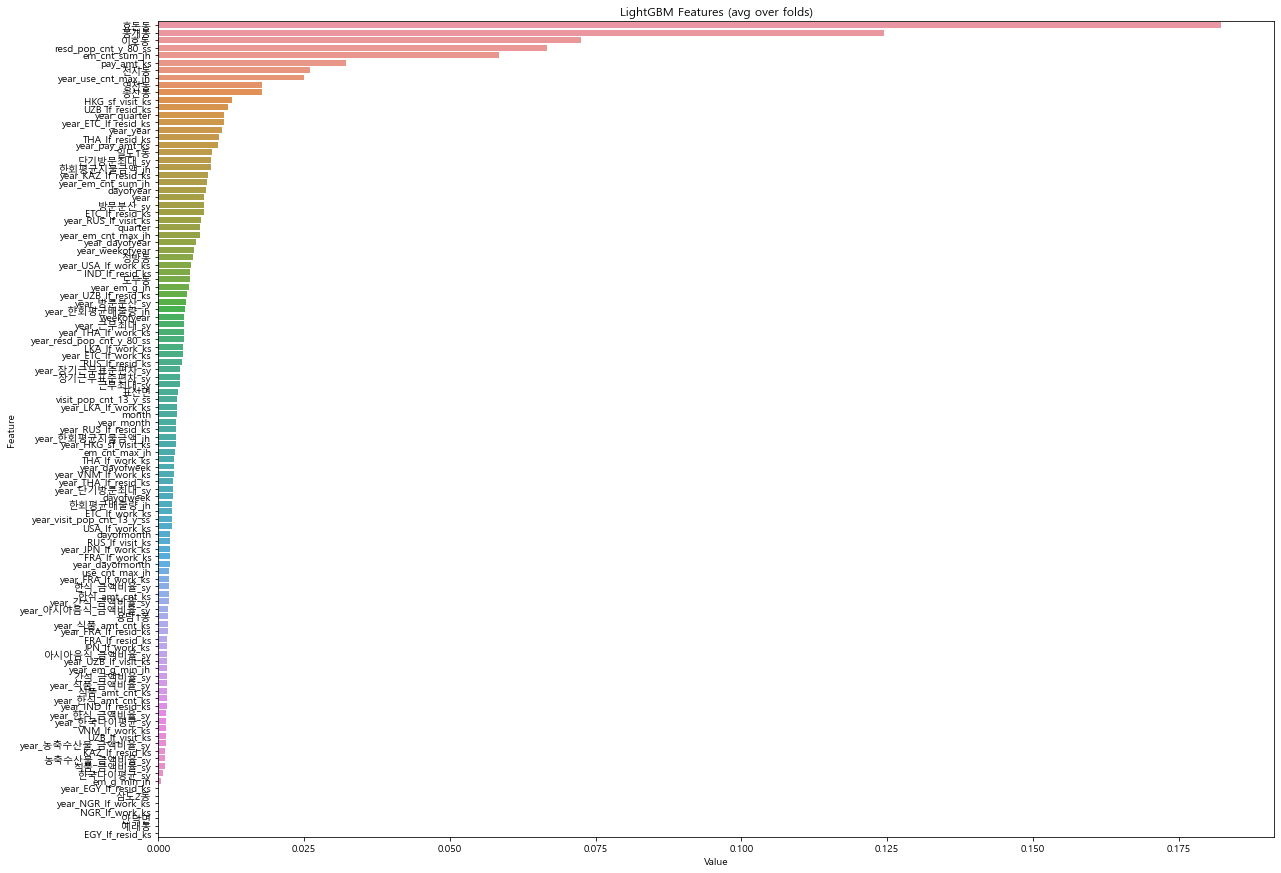

In [1591]:
# 군집0의 피쳐중요도
feature_imp = pd.DataFrame(sorted(zip(xgb_clf0_2.feature_importances_,X2_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.show()

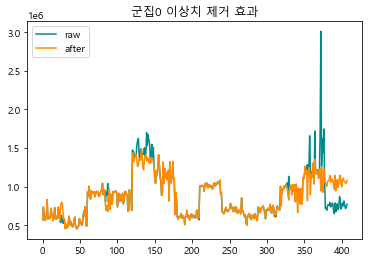

In [1592]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb0_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb0_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('군집0 이상치 제거 효과')
plt.show()

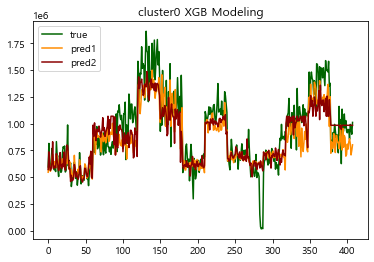

In [1593]:
#XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb0_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('cluster0 XGB Modeling')
plt.show()

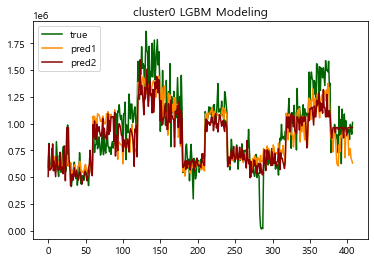

In [1594]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb0_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('cluster0 LGBM Modeling')
plt.show()

In [1595]:
#이상치제거
after_xgb0_1=(pd.DataFrame(pred_xgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb0_1=(pd.DataFrame(pred_lgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1597]:
#예측값 앙상블
pred0=pd.Series(gmean([after_xgb0_1,after_lgb0_1,pred_xgb0_2,pred_lgb0_2])).fillna(0)

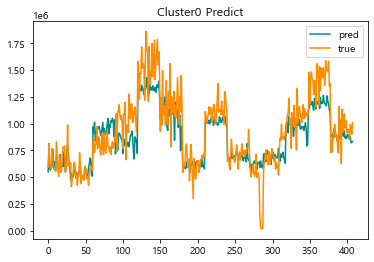

In [1598]:
#군집 0 최종예측
pd.Series(pred0).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster0 Predict')
plt.show()

In [1599]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred0)

136284.7153193876

In [1600]:
#음식물쓰레기 배출량 6월 예측값
sum(pred0)

353772101.3655906

In [1601]:
#음식물쓰레기 6월 배출량
sum(y2_test)

377384350.0

In [1602]:
c0=pd.DataFrame({'cluster0':pred0})

In [1603]:
c0.to_csv('predict/ml_cl0.csv',index=False)

**7월예측하기**

In [1604]:
after_july_xgb0_1=(pd.DataFrame(july_xgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1605]:
after_july_lgb0_1=(pd.DataFrame(july_lgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1606]:
july_pred0=pd.Series(gmean([after_july_xgb0_1,after_july_lgb0_1,july_xgb0_2,july_lgb0_2])).fillna(0)

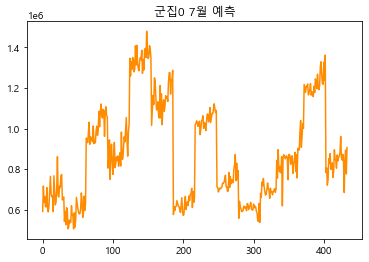

In [1607]:
july_pred0.plot(color='darkorange')
plt.title('군집0 7월 예측')
plt.show()

## Cluster1

In [1608]:
featureset1=pd.read_csv('features/군집1_feature_corona.csv')
featureset1=featureset1.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1609]:
X,y=create_features(featureset1,0,'em_g_jh')

In [1610]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1611]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1612]:
y2_test.to_csv('predict/cl1_test.csv',index=False)

In [1613]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1) 

In [1614]:
#XGB 차이예측
pred_xgb1_1, july_xgb1_1, xgb_clf1_1=model(BO_xgb1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -1.062e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -1.01e+06 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -9.407e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -9.113e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -1.363e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -9.531e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -1.204e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -9.283e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -9.539e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -1.006e+0 |  3.353    |  0.3551   |  6.2

In [1615]:
#XGB 직접예측
pred_xgb1_2, july_xgb1_2, xgb_clf1_2=model(BO_xgb2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -7.138e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -4.795e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -7.491e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -4.322e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -1.109e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -5.548e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -9.23e+05 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -5.63e+05 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -8.044e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -4.959e+0 |  3.353    |  0.3551   |  6.2

In [1616]:
#LGBM 차이예측
pred_lgb1_1, july_lgb1_1, lgb_clf1_1=model(BO_lgbm1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.324e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -9.368e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -1.095e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -1.048e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -1.462e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -1.103e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -1.25e+06 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1617]:
#LGBM 직접예측
pred_lgb1_2, july_lgb1_2, lgb_clf1_2=model(BO_lgbm2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -7.794e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -4.638e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -4.267e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -4.798e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -7.95e+05 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -6.307e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -7.395e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

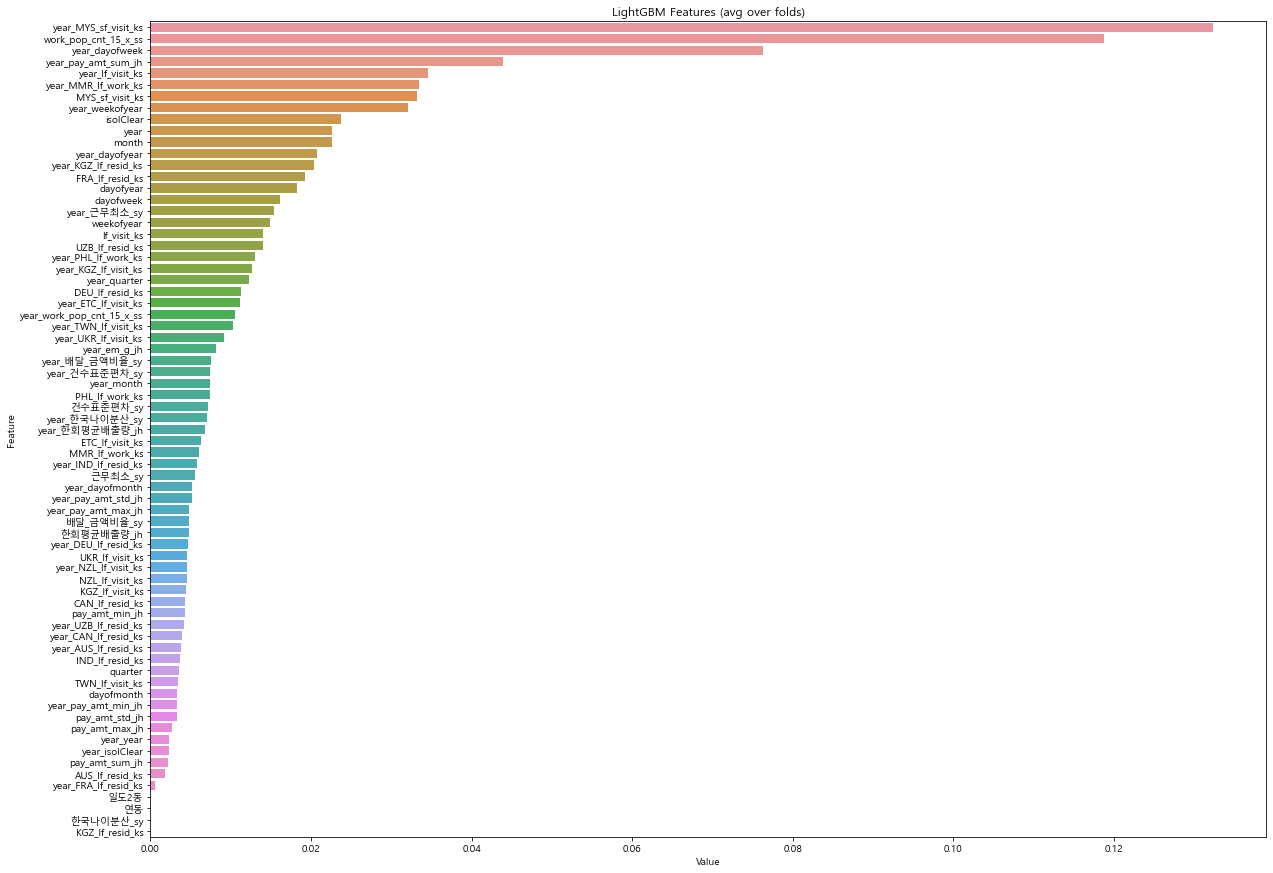

In [1618]:
# 군집1의 피쳐중요도
feature_imp = pd.DataFrame(sorted(zip(xgb_clf1_2.feature_importances_,X2_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.show()

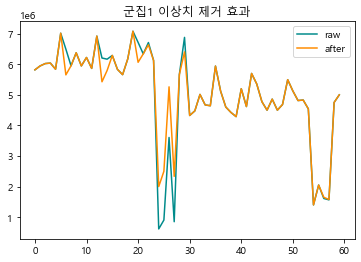

In [1619]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb1_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb1_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('군집1 이상치 제거 효과')
plt.show()

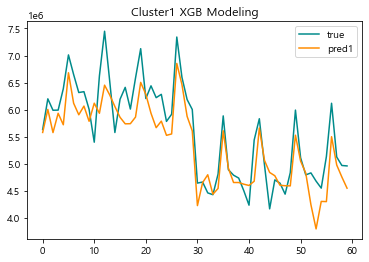

In [1620]:
#XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkcyan')
pd.Series(pred_xgb1_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
plt.legend()
plt.title('Cluster1 XGB Modeling')
plt.show()

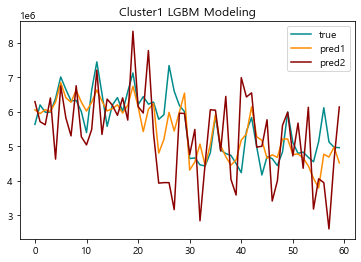

In [1621]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkcyan')
pd.Series(pred_lgb1_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster1 LGBM Modeling')
plt.show()

In [1622]:
#이상치제거
after_xgb1_1=(pd.DataFrame(pred_xgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb1_1=(pd.DataFrame(pred_lgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1624]:
#예측값 앙상블
pred1=pd.Series(gmean([after_xgb1_1,after_lgb1_1,pred_xgb1_2,pred_lgb1_2])).fillna(0)

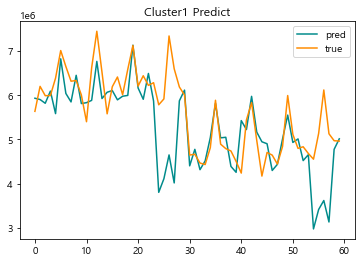

In [1625]:
#군집1 최종 예측
pd.Series(pred1).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster1 Predict')
plt.show()

In [1626]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred1)

541693.2377624969

In [1628]:
#음식물쓰레기 배출량 6월 예측값
sum(pred1)

315504764.18089277

In [1630]:
#음식물쓰레기 6월 배출량
sum(y2_test)

336870810.0

In [1631]:
c1=pd.DataFrame({'cluster1':pred1})

In [1632]:
c1.to_csv('predict/ml_cl1.csv',index=False)

**7월예측하기**

In [1633]:
after_july_xgb1_1=(pd.DataFrame(july_xgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1634]:
after_july_lgb1_1=(pd.DataFrame(july_lgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1635]:
july_pred1=pd.Series(gmean([after_july_xgb1_1,after_july_lgb1_1,july_xgb1_2,july_lgb1_2])).fillna(0)

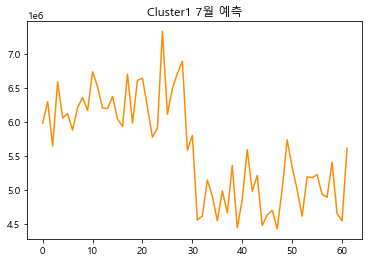

In [1636]:
july_pred1.plot(c='darkorange')
plt.title('Cluster1 7월 예측')
plt.show()

## Cluster2

In [1972]:
featureset2=pd.read_csv('features/군집2_feature_corona.csv')
featureset2=featureset2.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1973]:
X,y=create_features(featureset2,0,'em_g_jh')

In [1974]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1975]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1641]:
y2_test.to_csv('predict/cl2_test.csv',index=False)

In [15]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1)  

In [1643]:
#XGB 차이예측
pred_xgb2_1, july_xgb2_1, xgb_clf2_1=model(BO_xgb1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -5.559e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -5.17e+05 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -5.714e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -4.038e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -6.32e+05 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -4.146e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -5.766e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -4.76e+05 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -4.369e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -4.553e+0 |  3.353    |  0.3551   |  6.2

In [1644]:
#XGB 직접예측
pred_xgb2_2, july_xgb2_2, xgb_clf2_2=model(BO_xgb2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -4.677e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -4.279e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -5.795e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -3.388e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -8.065e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -3.858e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -5.523e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -4.407e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -4.169e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -3.512e+0 |  3.353    |  0.3551   |  6.2

In [1645]:
#LGBM 차이예측
pred_lgb2_1, july_lgb2_1, lgb_clf2_1=model(BO_lgbm1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -3.915e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -3.689e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -3.806e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -3.537e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -5.737e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -6.634e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -4.478e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1646]:
#LGBM 직접예측
pred_lgb2_2, july_lgb2_2, lgb_clf2_2=model(BO_lgbm2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -4.914e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -4.055e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -3.985e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -3.722e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -5.38e+05 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -4.83e+05 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -5.007e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

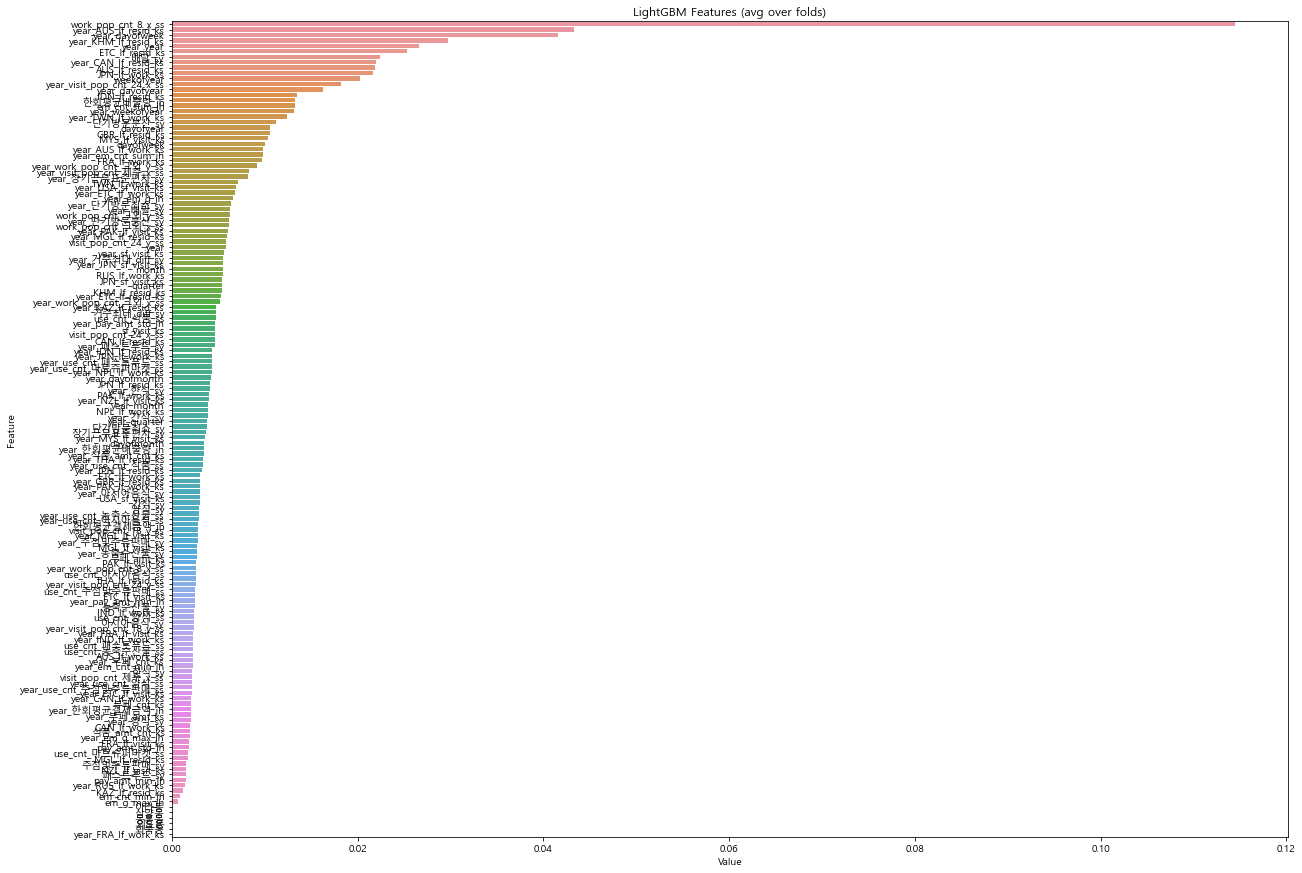

In [1647]:
# 군집2의 피쳐중요도
feature_imp = pd.DataFrame(sorted(zip(xgb_clf2_2.feature_importances_,X2_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.show()

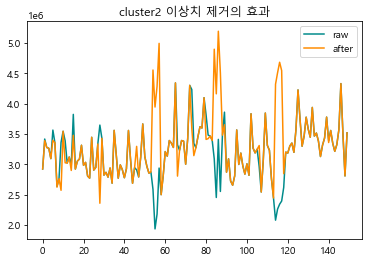

In [1648]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb2_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb2_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.title('cluster2 이상치 제거의 효과')
plt.legend()
plt.show()

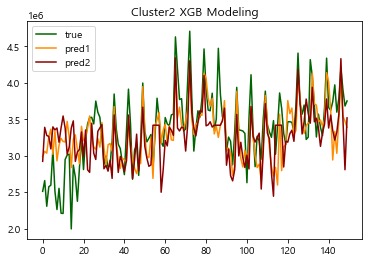

In [1649]:
#XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb2_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.title('Cluster2 XGB Modeling')
plt.legend()
plt.show()

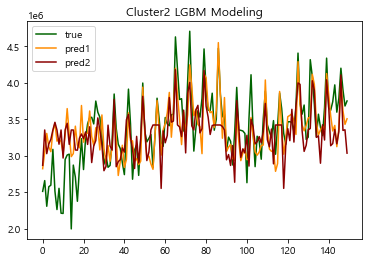

In [1650]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb2_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.title('Cluster2 LGBM Modeling')
plt.legend()
plt.show()

In [1651]:
#이상치제거
after_xgb2_1=(pd.DataFrame(pred_xgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb2_1=(pd.DataFrame(pred_lgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1653]:
#예측값 앙상블
pred2=pd.Series(gmean([after_xgb2_1,after_lgb2_1,pred_xgb2_2,pred_lgb2_2])).fillna(0)

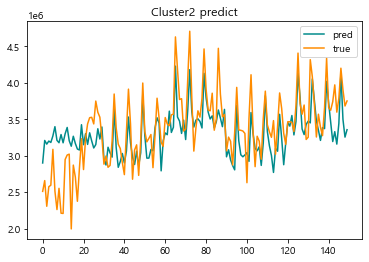

In [1976]:
#군집 2 최종예측
pd.Series(pred2).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.title('Cluster2 predict')
plt.legend()

In [1655]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred2)

290262.2441930587

In [1657]:
#음식물쓰레기 배출량 6월 예측값
sum(pred2)

495538556.5579906

In [1659]:
#음식물쓰레기 6월 배출량
sum(y2_test)

505734650.0

In [1660]:
c2=pd.DataFrame({'cluster2':pred2})

In [1661]:
c2.to_csv('predict/ml_cl2.csv',index=False)

**7월예측하기**

In [1662]:
after_july_xgb2_1=(pd.DataFrame(july_xgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1663]:
after_july_lgb2_1=(pd.DataFrame(july_lgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1664]:
july_pred2=pd.Series(gmean([after_july_xgb2_1,after_july_lgb2_1,july_xgb2_2,july_lgb2_2])).fillna(0)

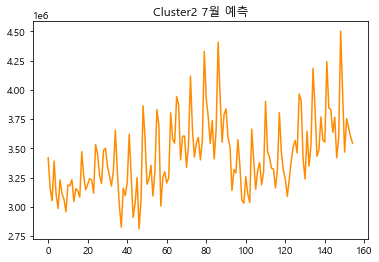

In [1665]:
july_pred2.plot(color='darkorange')
plt.title('Cluster2 7월 예측')
plt.show()

## Cluster3

In [1666]:
featureset3=pd.read_csv('features/군집3_feature_corona.csv')
featureset3=featureset3.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1667]:
X,y=create_features(featureset3,0,'em_g_jh')

In [1668]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1669]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1670]:
y2_test.to_csv('predict/cl3_test.csv',index=False)

In [1671]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1)  

In [1672]:
#XGB 차이예측
pred_xgb3_1, july_xgb3_1, xgb_clf3_1=model(BO_xgb1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.851e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -3.033e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -3.214e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -2.617e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -4.851e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -2.756e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -4.207e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -3.44e+05 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -2.908e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -2.715e+0 |  3.353    |  0.3551   |  6.2

In [1673]:
#XGB 직접예측
pred_xgb3_2, july_xgb3_2, xgb_clf3_2=model(BO_xgb2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.714e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -3.092e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -3.421e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -2.579e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -4.415e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -2.765e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -4.247e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -3.566e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -3.107e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -2.563e+0 |  3.353    |  0.3551   |  6.2

In [1674]:
#LGBM 차이예측
pred_lgb3_1, july_lgb3_1, lgb_clf3_1=model(BO_lgbm1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -3.07e+05 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -2.718e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -2.972e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -2.628e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -3.993e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -3.982e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -2.991e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1675]:
#LGBM 직접예측
pred_lgb3_2, july_lgb3_2, lgb_clf3_2=model(BO_lgbm2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -2.877e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -2.689e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -2.87e+05 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -2.524e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -3.871e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -3.35e+05 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -3.311e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

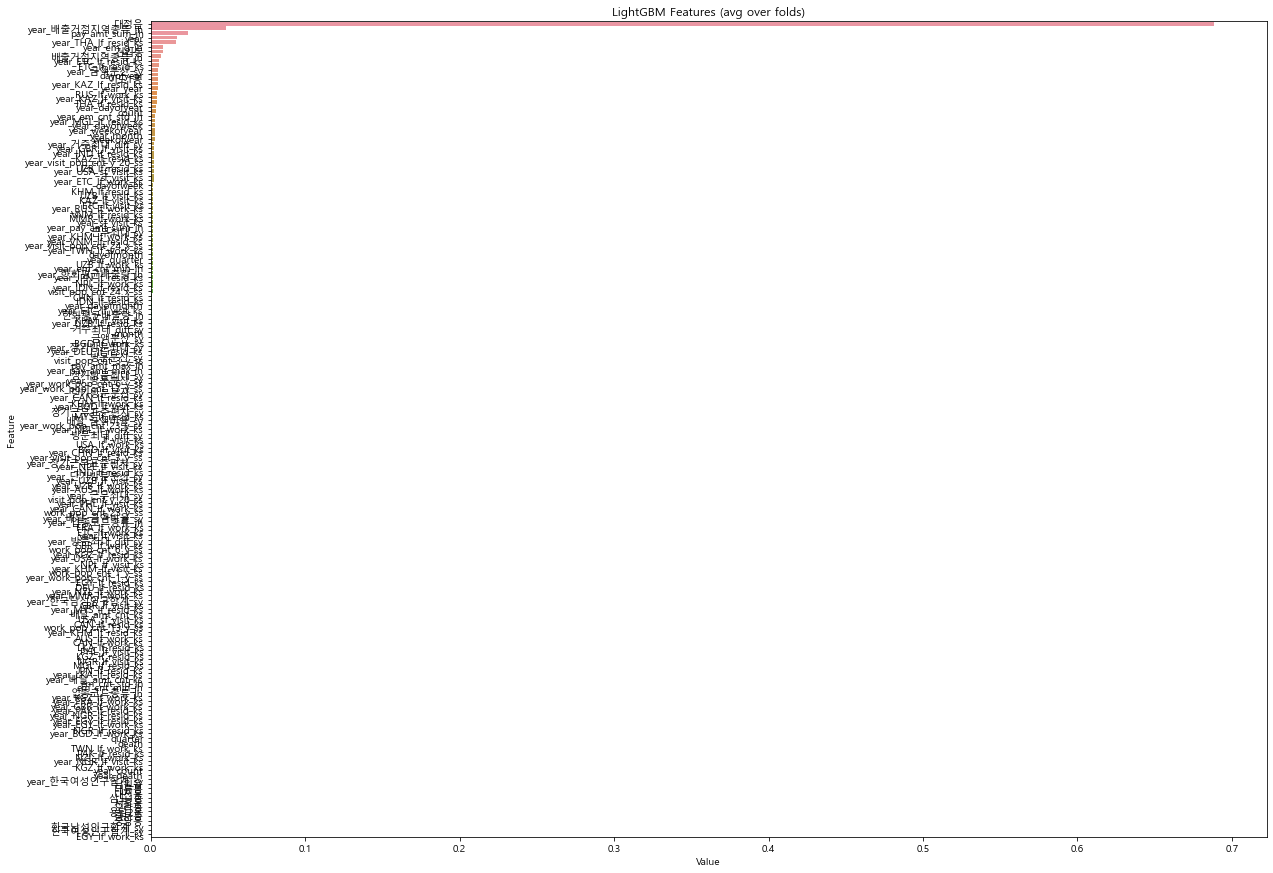

In [1676]:
# 군집3의 피쳐중요도
feature_imp = pd.DataFrame(sorted(zip(xgb_clf3_2.feature_importances_,X2_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.show()

**군집3은 이상치 제거의 효과가 없음**

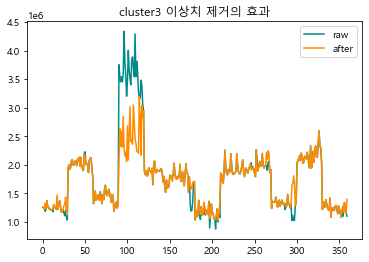

In [1677]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb3_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb3_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('cluster3 이상치 제거의 효과')
plt.show()

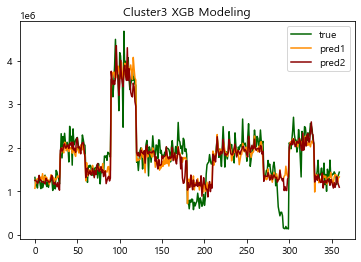

In [1678]:
#XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb3_2).plot(label='pred1',color='darkorange')
(pd.Series(pred_xgb3_1) +pd.Series(y1_plus)).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster3 XGB Modeling')
plt.show()

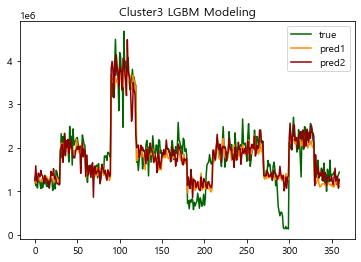

In [1679]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb3_2).plot(label='pred1',color='darkorange')
(pd.Series(pred_lgb3_1) +pd.Series(y1_plus)).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster3 LGBM Modeling')
plt.show()

In [1680]:
#예측값 앙상블
pred3=pd.Series(gmean([(pd.Series(pred_xgb3_1) +y1_plus),(pd.Series(pred_lgb3_1) +y1_plus),pred_xgb3_2,pred_lgb3_2])).fillna(0)

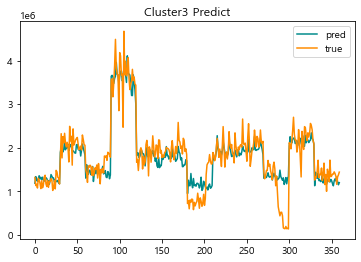

In [1681]:
#군집 3 최종예측
pd.Series(pred3).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster3 Predict')
plt.show()

In [1682]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred3)

239495.80153712706

In [1684]:
#음식물쓰레기 배출량 6월 예측값
sum(pred3)

647920708.902049

In [1686]:
#음식물쓰레기 6월 배출량
sum(y2_test)

658290000.0

In [1687]:
c3=pd.DataFrame({'cluster3':pred3})

In [1688]:
c3.to_csv('predict/ml_cl3.csv',index=False)

**7월예측하기**

In [1689]:
july_pred3=pd.Series(gmean([july_xgb3_1+july1_plus,july_lgb3_1+july1_plus,july_xgb3_2,july_lgb3_2])).fillna(0)

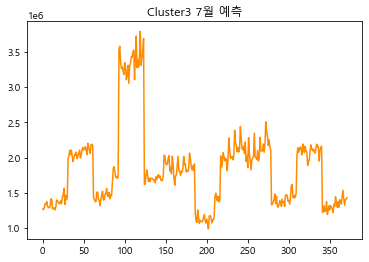

In [1690]:
july_pred3.plot(color='darkorange')
plt.title('Cluster3 7월 예측')
plt.show()

## Cluster4

In [1691]:
featureset4=pd.read_csv('features/군집4_feature_corona.csv')
featureset4=featureset4.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1692]:
X,y=create_features(featureset4,0,'em_g_jh')

In [1693]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1694]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1695]:
y2_test.to_csv('predict/cl4_test.csv',index=False)

In [1696]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1) 

In [1697]:
#XGB 차이예측
pred_xgb4_1, july_xgb4_1, xgb_clf4_1=model(BO_xgb1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -8.945e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -8.095e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -7.943e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -7.14e+05 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -8.575e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -7.233e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -9.263e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -8.153e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -7.99e+05 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -7.08e+05 |  3.353    |  0.3551   |  6.2

In [1698]:
#XGB 직접예측
pred_xgb4_2, july_xgb4_2, xgb_clf4_2=model(BO_xgb2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -8.361e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -8.016e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -8.084e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -7.609e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -8.217e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -7.671e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -7.882e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -7.413e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -7.598e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -7.337e+0 |  3.353    |  0.3551   |  6.2

In [1699]:
#LGBM 차이예측
pred_lgb4_1, july_lgb4_1, lgb_clf4_1=model(BO_lgbm1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -6.658e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -7.594e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -8.567e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -6.971e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -9.261e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -9.749e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -7.498e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1700]:
#LGBM 직접예측
pred_lgb4_2, july_lgb4_2, lgb_clf4_2=model(BO_lgbm2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -6.377e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -6.902e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -6.927e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -7.354e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -6.519e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -7.558e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -6.589e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

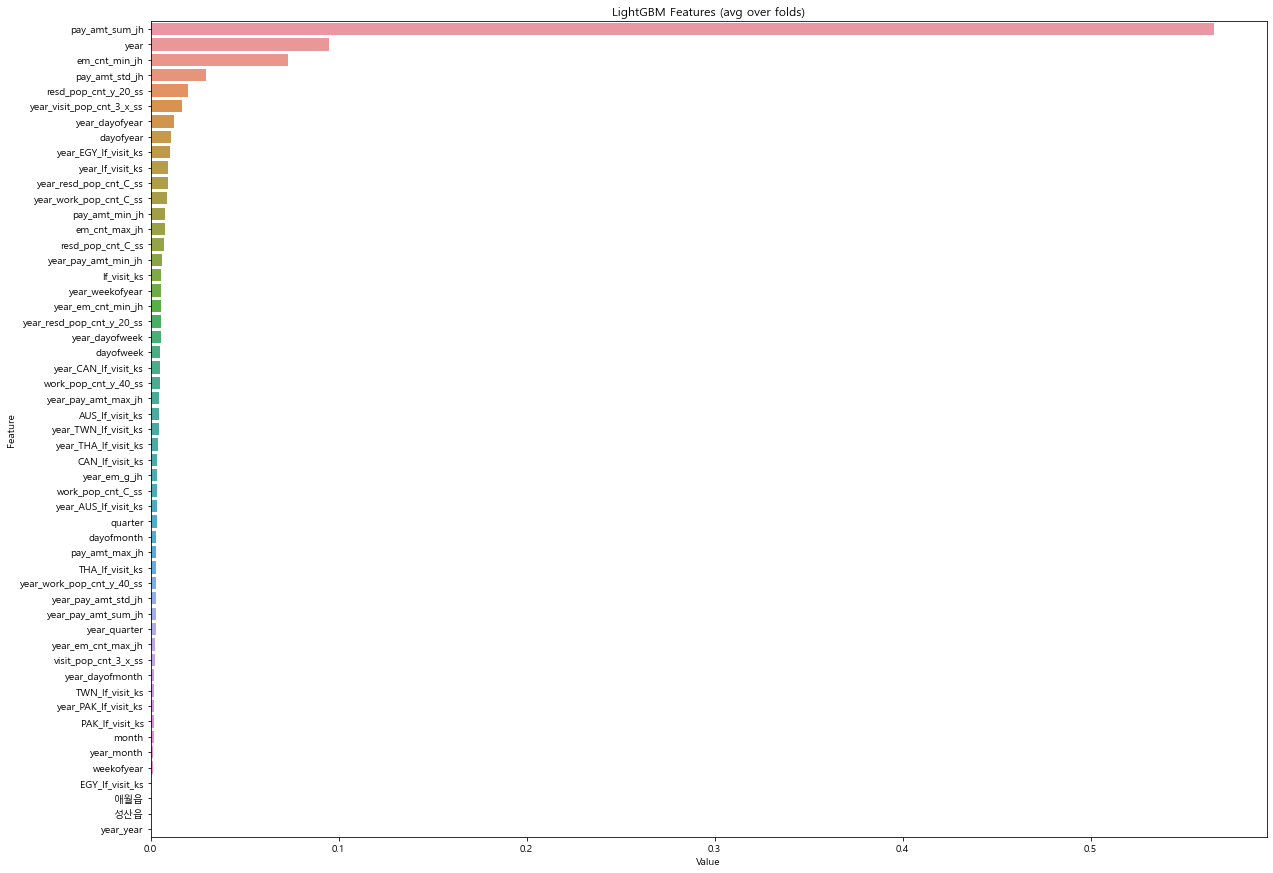

In [1701]:
# 군집0의 피쳐중요도
feature_imp = pd.DataFrame(sorted(zip(lgb_clf4_2.feature_importances_,X2_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.show()

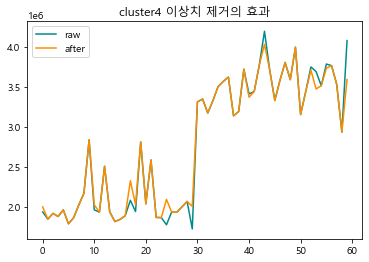

In [1702]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb4_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb4_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('cluster4 이상치 제거의 효과')
plt.show()

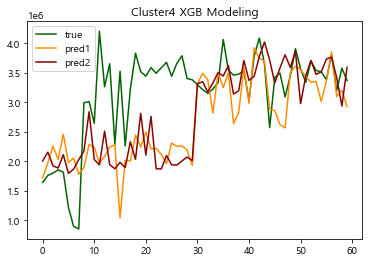

In [1703]:
#XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb4_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster4 XGB Modeling')
plt.show()

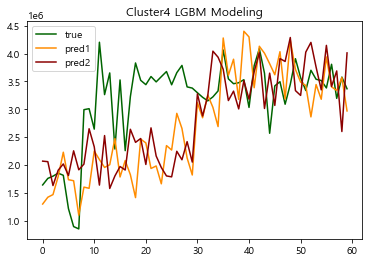

In [1704]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb4_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster4 LGBM Modeling')
plt.show()

In [1705]:
#이상치제거
after_xgb4_1=(pd.DataFrame(pred_xgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb4_1=(pd.DataFrame(pred_lgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1707]:
#예측값 앙상블
pred4=pd.Series(gmean([after_xgb4_1,after_lgb4_1,pred_xgb4_2,pred_lgb4_2])).fillna(0)

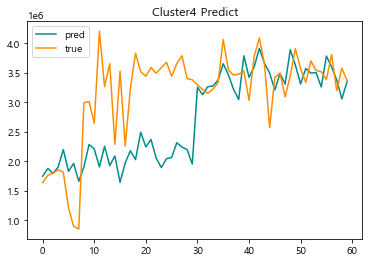

In [1708]:
#군집 4 최종예측
pd.Series(pred4).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster4 Predict')
plt.show()

In [1709]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred4)

628212.9243924727

In [1711]:
#음식물쓰레기 배출량 6월 예측값
sum(pred4)

164579181.58788508

In [1713]:
#음식물쓰레기 6월 배출량
sum(y2_test)

189445160.0

In [1714]:
c4=pd.DataFrame({'cluster4':pred4})

In [1715]:
c4.to_csv('predict/ml_cl4.csv',index=False)

**7월예측하기**

In [1716]:
after_july_xgb4_1=(pd.DataFrame(july_xgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_july_lgb4_1=(pd.DataFrame(july_lgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1718]:
july_pred4=pd.Series(gmean([after_july_xgb4_1,after_july_lgb4_1,july_xgb4_2,july_lgb4_2])).fillna(0)

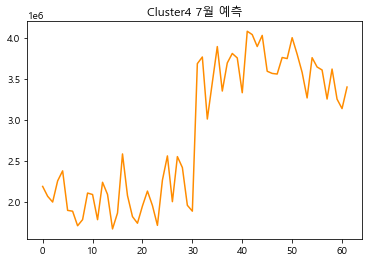

In [1719]:
july_pred4.plot(color='darkorange')
plt.title('Cluster4 7월 예측')
plt.show()

## Cluster5

In [1720]:
featureset5=pd.read_csv('features/군집5_feature_corona.csv')
featureset5=featureset5.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1721]:
X,y=create_features(featureset5,0,'em_g_jh')

In [1722]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1723]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1724]:
y2_test.to_csv('predict/cl5_test.csv',index=False)

In [1725]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1) 

In [1726]:
#XGB 차이예측
pred_xgb5_1, july_xgb5_1, xgb_clf5_1=model(BO_xgb1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -1.452e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -1.055e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -9.991e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -8.694e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -1.412e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -8.697e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -1.512e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -1.204e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -1.103e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -9.782e+0 |  3.353    |  0.3551   |  6.2

In [1727]:
#XGB 직접예측
pred_xgb5_2, july_xgb5_2, xgb_clf5_2=model(BO_xgb2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -1.142e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -8.826e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -8.73e+05 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -8.774e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -1.338e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -8.262e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -1.329e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -7.944e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -8.23e+05 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -7.244e+0 |  3.353    |  0.3551   |  6.2

In [1728]:
#LGBM 차이예측
pred_lgb5_1, july_lgb5_1, lgb_clf5_1=model(BO_lgbm1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -8e+05    |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -1.101e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -1.345e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -9.183e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -1.665e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -1.529e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -1.27e+06 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1729]:
#LGBM 직접예측
pred_lgb5_2, july_lgb5_2, lgb_clf5_2=model(BO_lgbm2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -8.195e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -8.479e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -8.005e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -6.02e+05 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -1.036e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -8.678e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -8.918e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

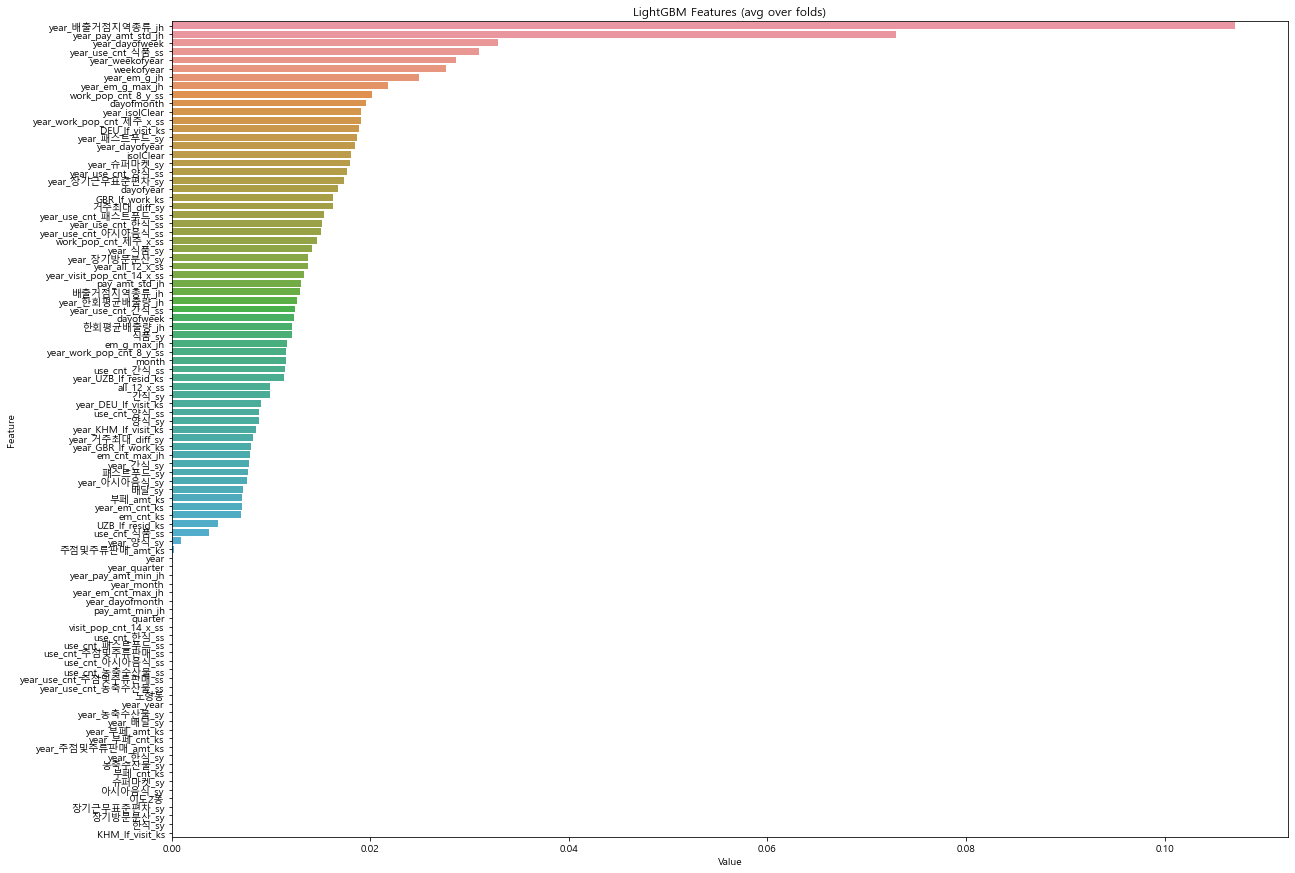

In [1730]:
# 군집5의 피쳐중요도
feature_imp = pd.DataFrame(sorted(zip(lgb_clf5_2.feature_importances_,X2_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.show()

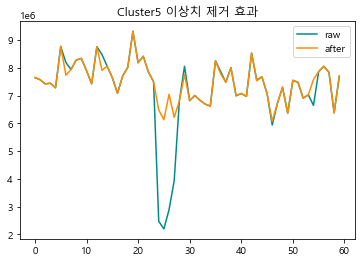

In [1731]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb5_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb5_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('Cluster5 이상치 제거 효과')
plt.show()

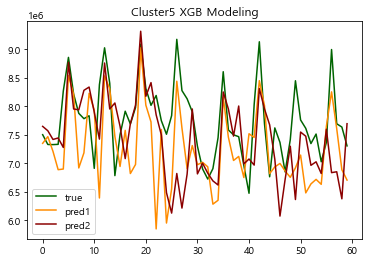

In [1732]:
#XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb5_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster5 XGB Modeling')
plt.show()

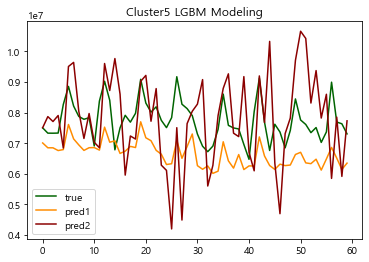

In [1733]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb5_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster5 LGBM Modeling')
plt.show()

In [1734]:
#이상치제거
after_xgb5_1=(pd.DataFrame(pred_xgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb5_1=(pd.DataFrame(pred_lgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1736]:
#예측값 앙상블
pred5=pd.Series(gmean([after_xgb5_1,after_lgb5_1,pred_xgb5_2,pred_lgb5_2])).fillna(0)

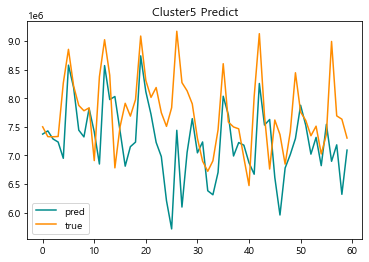

In [1737]:
#군집 5 최종예측
pd.Series(pred5).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true', color='darkorange')
plt.legend()
plt.title('Cluster5 Predict')
plt.show()

In [1738]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred5)

625999.4936144347

In [1740]:
#음식물쓰레기 배출량 6월 예측값
sum(pred5)

435117220.2789466

In [1742]:
#음식물쓰레기 6월 배출량
sum(y2_test)

464492450.0

In [1743]:
c5=pd.DataFrame({'cluster5':pred5})

In [1744]:
c5.to_csv('predict/ml_cl5.csv',index=False)

**7월예측하기**

In [1745]:
after_july_xgb5_1=(pd.DataFrame(july_xgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_july_lgb5_1=(pd.DataFrame(july_lgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1747]:
july_pred5=pd.Series(gmean([after_july_xgb5_1,after_july_lgb5_1,july_xgb5_2,july_lgb5_2])).fillna(0)

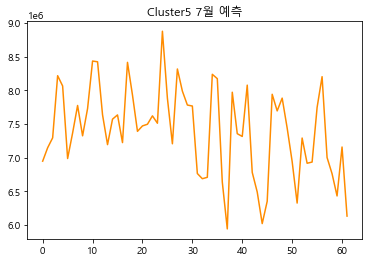

In [1748]:
july_pred5.plot(color='darkorange')
plt.title('Cluster5 7월 예측')
plt.show()

## Cluster6

In [1749]:
featureset6=pd.read_csv('features/군집6_feature_corona.csv')
featureset6=featureset6.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1750]:
X,y=create_features(featureset6,0,'em_g_jh')

In [1751]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1752]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1753]:
y2_test.to_csv('predict/cl6_test.csv',index=False)

In [1754]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1) 

In [1755]:
#XGB 차이예측
pred_xgb6_1, july_xgb6_1, xgb_clf6_1=model(BO_xgb1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.7305   |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        |  0.772    |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        |  0.6734   |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        |  0.7779   |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        |  0.7434   |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        |  0.4483   |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        |  0.6478   |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        |  0.7485   |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        |  0.74     |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       |  0.7631   |  3.353    |  0.3551   |  6.2

In [1756]:
#XGB 직접예측
pred_xgb6_2, july_xgb6_2, xgb_clf6_2=model(BO_xgb2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.8018   |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        |  0.7492   |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        |  0.8439   |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        |  0.7773   |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        |  0.8061   |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        |  0.7696   |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        |  0.7817   |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        |  0.7858   |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        |  0.7845   |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       |  0.7557   |  3.353    |  0.3551   |  6.2

In [1757]:
#LGBM 차이예측
pred_lgb6_1, july_lgb6_1, lgb_clf6_1=model(BO_lgbm1,X1_train,y1_train,X1_test,july1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.4525   |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -0.3943   |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -1.363    |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -0.8753   |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -1.145    |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -0.7745   |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -1.793    |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1758]:
#LGBM 직접예측
pred_lgb6_2, july_lgb6_2, lgb_clf6_2=model(BO_lgbm2,X2_train,y2_train,X2_test,july2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.2401   |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -0.3356   |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -0.8996   |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -0.7028   |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -0.444    |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -0.4319   |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -0.4889   |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

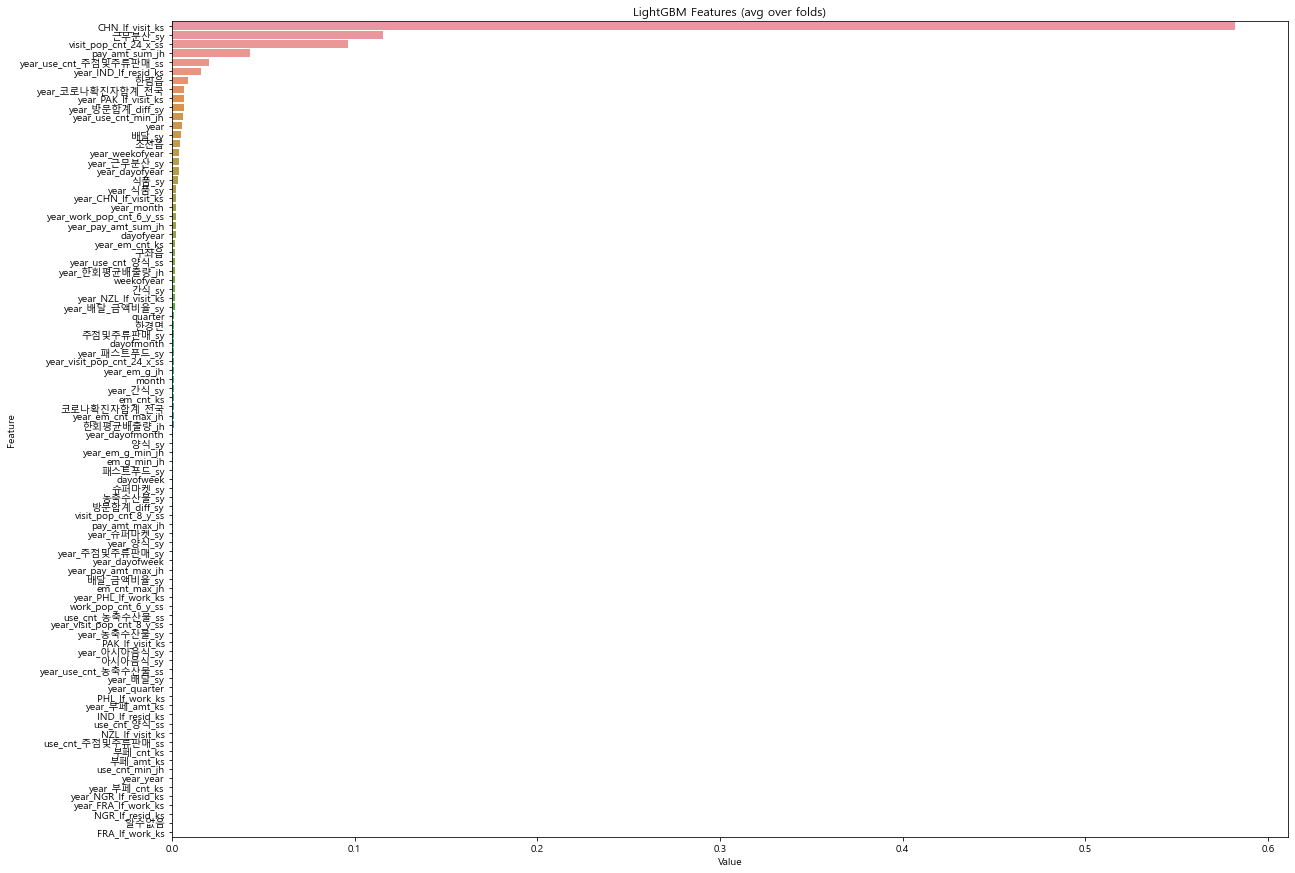

In [1759]:
# 군집6의 피쳐중요도
feature_imp = pd.DataFrame(sorted(zip(lgb_clf6_2.feature_importances_,X2_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.show()

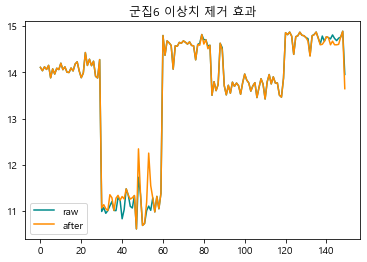

In [1760]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb6_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb6_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('군집6 이상치 제거 효과')
plt.show()

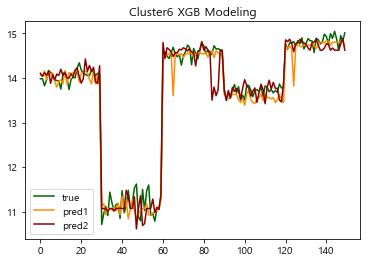

In [1761]:
#XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb6_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster6 XGB Modeling')
plt.show()

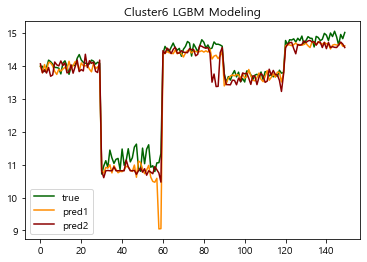

In [1762]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb6_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster6 LGBM Modeling')
plt.show()

In [1763]:
#이상치제거
after_xgb6_1=(pd.DataFrame(pred_xgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb6_1=(pd.DataFrame(pred_lgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)[0])

In [1765]:
#예측값 앙상블
pred6=pd.Series(gmean([after_xgb6_1,after_lgb6_1,pred_xgb6_2,pred_lgb6_2])).fillna(0)

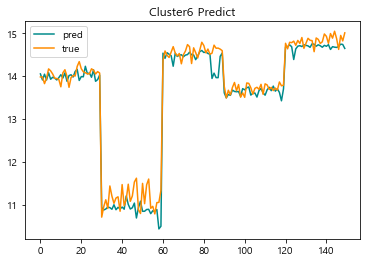

In [1766]:
#군집 6 최종예측
pd.Series(pred6).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster6 Predict')
plt.show()

In [1767]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred6)

0.17778467508846543

In [1769]:
#음식물쓰레기 배출량 6월 예측값
sum(pred6)

2029.2825103473972

In [1771]:
#음식물쓰레기 6월 배출량
sum(y2_test)

2048.5049295181952

In [1772]:
c6=pd.DataFrame({'cluster6':pred6})

In [1773]:
c6.to_csv('predict/ml_cl6.csv',index=False)

**7월예측하기**

In [1774]:
after_july_xgb6_1=(pd.DataFrame(july_xgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_july_lgb6_1=(pd.DataFrame(july_lgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(july1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1776]:
july_pred6=pd.Series(gmean([after_july_xgb6_1,after_july_lgb6_1,july_xgb6_2,july_lgb6_2])).fillna(0)

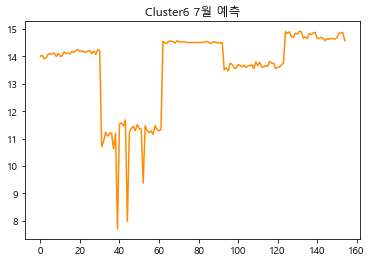

In [1777]:
july_pred6.plot(color='darkorange')
plt.title('Cluster6 7월 예측')
plt.show()

### 최종 7월

In [1778]:
july_predict=pd.DataFrame({'ml0':july_pred0,'ml1':july_pred1,'ml2':july_pred2,'ml3':july_pred3,'ml4':july_pred4,'ml5':july_pred5,'ml6':july_pred6})
july_predict.to_csv('predict/ml_07_predict.csv')

# 8월 예측 모델링

- 8월 예측은 2달전의 피쳐셋을 통해 학습을 진행한다
- 이후의 방식은 모두 7월 예측 방식과 동일합니다.

## Cluster0

In [1779]:
featureset0=pd.read_csv('features/군집0_feature_corona.csv')
featureset0=featureset0.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1780]:
X,y=create_features(featureset0,1,'em_g_jh') #1은 8월

In [1781]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1782]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1784]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1)  

In [1785]:
#XGB 차이예측
pred_xgb0_1, august_xgb0_1, xgb_clf0_1=model(BO_xgb1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.536e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -2.093e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -1.885e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -1.512e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -2.435e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -1.673e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -2.744e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -2.064e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -1.99e+05 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -1.71e+05 |  3.353    |  0.3551   |  6.2

In [1786]:
#LGBM 차이예측
pred_lgb0_1,august_lgb0_1,lgb_clf0_1=model(BO_lgbm1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.945e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -1.743e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -1.557e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -1.704e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -2.202e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -1.934e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -2.295e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1787]:
#XGB 직접예측
pred_xgb0_2, august_xgb0_2,xgb_clf0_2=model(BO_xgb2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.566e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -2.047e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -2.225e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -1.754e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -2.554e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -1.756e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -2.651e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -2.231e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -1.979e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -1.652e+0 |  3.353    |  0.3551   |  6.2

In [1788]:
#LGBM 직접예측
pred_lgb0_2,august_lgb0_2,lgb_clf0_2=model(BO_lgbm2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.538e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -1.87e+05 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -2.197e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -1.603e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -2.626e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -2.446e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -2.055e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

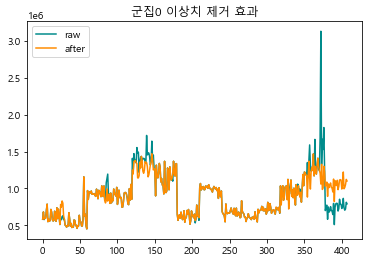

In [1789]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb0_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb0_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('군집0 이상치 제거 효과')
plt.show()

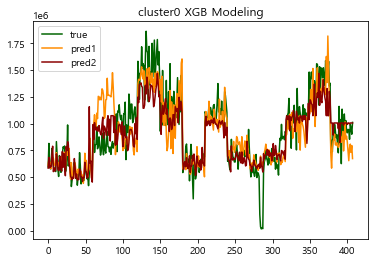

In [1790]:
#XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb0_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('cluster0 XGB Modeling')
plt.show()

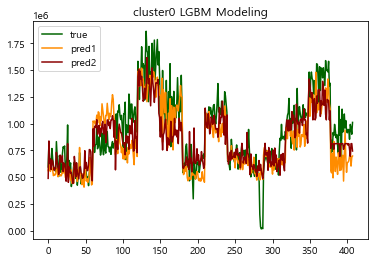

In [1791]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb0_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('cluster0 LGBM Modeling')
plt.show()

In [1792]:
#이상치 제거
after_xgb0_1=(pd.DataFrame(pred_xgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb0_1=(pd.DataFrame(pred_lgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1794]:
#예측값 앙상블
pred0=pd.Series(gmean([after_xgb0_1,after_lgb0_1,pred_xgb0_2,pred_lgb0_2])).fillna(0)

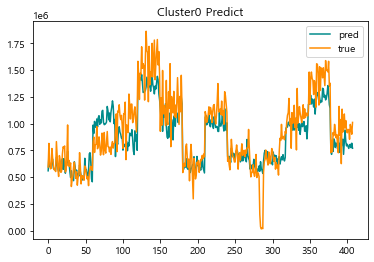

In [1795]:
#군집 0 최종예측
pd.Series(pred0).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster0 Predict')
plt.show()

In [1796]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred0)

143352.63220405023

In [1797]:
#음식물쓰레기 배출량 6월 예측값
sum(pred0)

353722475.03597176

In [1798]:
#음식물쓰레기 6월 배출량
sum(y2_test)

377384350.0

**8월예측하기**

In [1801]:
after_august_xgb0_1=(pd.DataFrame(august_xgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1802]:
after_august_lgb0_1=(pd.DataFrame(august_lgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1803]:
august_pred0=pd.Series(gmean([after_august_xgb0_1,after_august_lgb0_1,august_xgb0_2,august_lgb0_2])).fillna(0)

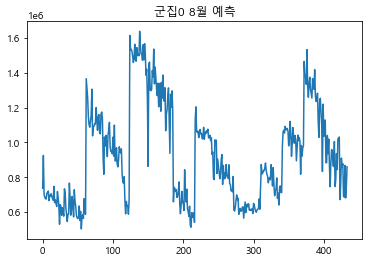

In [1804]:
august_pred0.plot()
plt.title('군집0 8월 예측')
plt.show()

## Cluster1

In [1805]:
featureset1=pd.read_csv('features/군집1_feature_corona.csv')
featureset1=featureset1.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1806]:
X,y=create_features(featureset1,0,'em_g_jh')

In [1807]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1808]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1810]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1) 

In [1811]:
# XGB 차이예측
pred_xgb1_1, august_xgb1_1, xgb_clf1_1=model(BO_xgb1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -1.062e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -1.01e+06 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -9.407e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -9.113e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -1.363e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -9.531e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -1.204e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -9.283e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -9.539e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -1.006e+0 |  3.353    |  0.3551   |  6.2

In [1812]:
# XGB 직접예측
pred_xgb1_2, august_xgb1_2, xgb_clf1_2=model(BO_xgb2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -7.138e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -4.795e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -7.491e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -4.322e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -1.109e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -5.548e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -9.23e+05 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -5.63e+05 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -8.044e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -4.959e+0 |  3.353    |  0.3551   |  6.2

In [1813]:
# LGBM 차이예측
pred_lgb1_1, august_lgb1_1, lgb_clf1_1=model(BO_lgbm1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -1.324e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -9.368e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -1.095e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -1.048e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -1.462e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -1.103e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -1.25e+06 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1814]:
# LGBM 직접예측
pred_lgb1_2, august_lgb1_2, lgb_clf1_2=model(BO_lgbm2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -7.794e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -4.638e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -4.267e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -4.798e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -7.95e+05 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -6.307e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -7.395e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

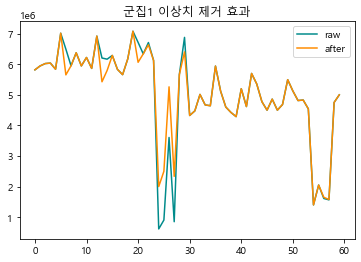

In [1816]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb1_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb1_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('군집1 이상치 제거 효과')
plt.show()

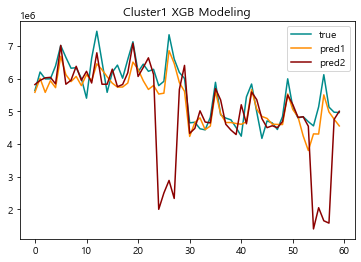

In [1817]:
# XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkcyan')
pd.Series(pred_xgb1_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster1 XGB Modeling')
plt.show()

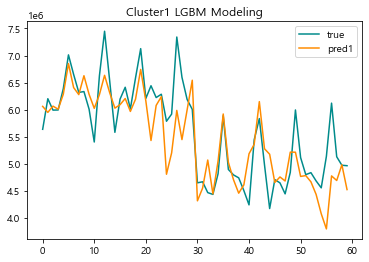

In [1818]:
# LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkcyan')
pd.Series(pred_lgb1_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb0_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
plt.legend()
plt.title('Cluster1 LGBM Modeling')
plt.show()

In [1819]:
#이상치제거
after_xgb1_1=(pd.DataFrame(pred_xgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb1_1=(pd.DataFrame(pred_lgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1821]:
#예측값 앙상블
pred1=pd.Series(gmean([after_xgb1_1,after_lgb1_1,pred_xgb1_2,pred_lgb1_2])).fillna(0)

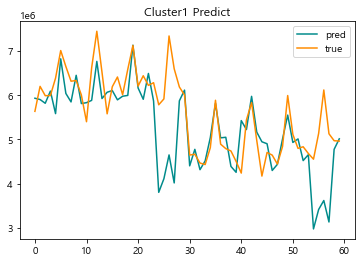

In [1822]:
#군집 1 최종예측
pd.Series(pred1).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster1 Predict')
plt.show()

In [1823]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred1)

541693.2377624969

In [1825]:
#음식물쓰레기 배출량 6월 예측값
sum(pred1)

315504764.18089277

In [1827]:
#음식물쓰레기 6월 배출량
sum(y2_test)

336870810.0

**8월예측하기**

In [1830]:
after_august_xgb1_1=(pd.DataFrame(august_xgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1831]:
after_august_lgb1_1=(pd.DataFrame(august_lgb1_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1832]:
august_pred1=pd.Series(gmean([after_august_xgb1_1,after_august_lgb1_1,august_xgb1_2,august_lgb1_2])).fillna(0)

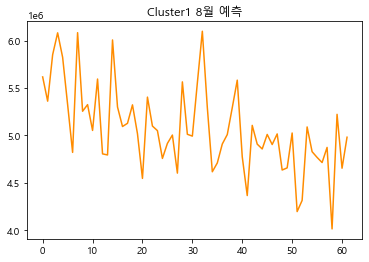

In [1833]:
august1_pred.plot(c='darkorange')
plt.title('Cluster1 8월 예측')
plt.show()

## Cluster2

In [1977]:
featureset2=pd.read_csv('features/군집2_feature_corona.csv')
featureset2=featureset2.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1978]:
X,y=create_features(featureset2,0,'em_g_jh')

In [1979]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1980]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1839]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1)  

In [1840]:
# XGB 차이예측
pred_xgb2_1, august_xgb2_1, xgb_clf2_1=model(BO_xgb1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -5.559e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -5.17e+05 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -5.714e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -4.038e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -6.32e+05 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -4.146e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -5.766e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -4.76e+05 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -4.369e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -4.553e+0 |  3.353    |  0.3551   |  6.2

In [1841]:
# XGB 직접예측
pred_xgb2_2, august_xgb2_2, xgb_clf2_2=model(BO_xgb2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -4.677e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -4.279e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -5.795e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -3.388e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -8.065e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -3.858e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -5.523e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -4.407e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -4.169e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -3.512e+0 |  3.353    |  0.3551   |  6.2

In [1842]:
# LGBM 차이예측
pred_lgb2_1, august_lgb2_1, lgb_clf2_1=model(BO_lgbm1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -3.915e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -3.689e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -3.806e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -3.537e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -5.737e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -6.634e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -4.478e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1843]:
# LGBM 직접예측
pred_lgb2_2, august_lgb2_2, lgb_clf2_2=model(BO_lgbm2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -4.914e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -4.055e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -3.985e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -3.722e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -5.38e+05 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -4.83e+05 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -5.007e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

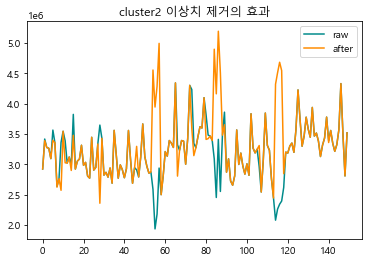

In [1845]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb2_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb2_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.title('cluster2 이상치 제거의 효과')
plt.legend()
plt.show()

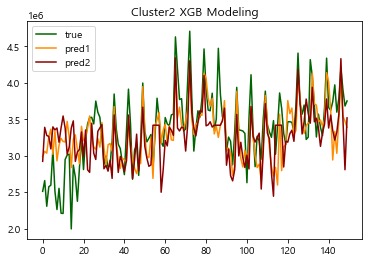

In [1846]:
# XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb2_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.title('Cluster2 XGB Modeling')
plt.legend()
plt.show()

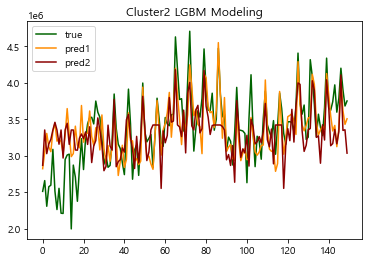

In [1847]:
# LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb2_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.title('Cluster2 LGBM Modeling')
plt.legend()
plt.show()

In [1848]:
#이상치제거
after_xgb2_1=(pd.DataFrame(pred_xgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb2_1=(pd.DataFrame(pred_lgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1850]:
#예측값 앙상블
pred2=pd.Series(gmean([after_xgb2_1,after_lgb2_1,pred_xgb2_2,pred_lgb2_2])).fillna(0)

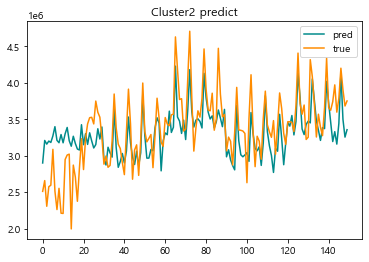

In [1981]:
#군집 2 최종예측
pd.Series(pred2).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.title('Cluster2 predict')
plt.legend()
plt.show()

In [1852]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred2)

290262.2441930587

In [1854]:
#음식물쓰레기 배출량 6월 예측값
sum(pred2)

495538556.5579906

In [1856]:
#음식물쓰레기 6월 배출량
sum(y2_test)

505734650.0

**8월예측하기**

In [1859]:
after_august_xgb2_1=(pd.DataFrame(august_xgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1860]:
after_august_lgb2_1=(pd.DataFrame(august_lgb2_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1861]:
august_pred2=pd.Series(gmean([after_august_xgb2_1,after_august_lgb2_1,august_xgb2_2,august_lgb2_2])).fillna(0)

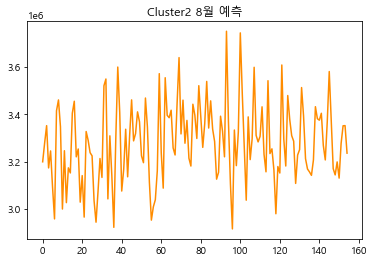

In [1862]:
august_pred2.plot(color='darkorange')
plt.title('Cluster2 8월 예측')
plt.show()

## Cluster3

In [1863]:
featureset3=pd.read_csv('features/군집3_feature_corona.csv')
featureset3=featureset3.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1864]:
X,y=create_features(featureset3,0,'em_g_jh')

In [1865]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1866]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1868]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1)  

In [1869]:
# XGB 차이예측
pred_xgb3_1, august_xgb3_1, xgb_clf3_1=model(BO_xgb1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.851e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -3.033e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -3.214e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -2.617e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -4.851e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -2.756e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -4.207e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -3.44e+05 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -2.908e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -2.715e+0 |  3.353    |  0.3551   |  6.2

In [1870]:
# XGB 직접예측
pred_xgb3_2, august_xgb3_2, xgb_clf3_2=model(BO_xgb2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.714e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -3.092e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -3.421e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -2.579e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -4.415e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -2.765e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -4.247e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -3.566e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -3.107e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -2.563e+0 |  3.353    |  0.3551   |  6.2

In [1871]:
# LGBM 차이예측
pred_lgb3_1, august_lgb3_1, lgb_clf3_1=model(BO_lgbm1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -3.07e+05 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -2.718e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -2.972e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -2.628e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -3.993e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -3.982e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -2.991e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1872]:
# LGBM 직접에측
pred_lgb3_2, august_lgb3_2, lgb_clf3_2=model(BO_lgbm2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -2.877e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -2.689e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -2.87e+05 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -2.524e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -3.871e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -3.35e+05 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -3.311e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

**군집3은 이상치 제거의 효과가 없음**

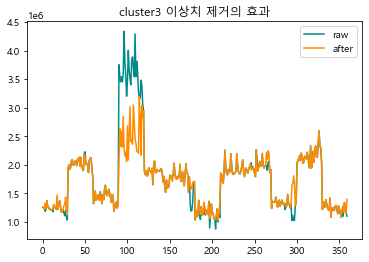

In [1873]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb3_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb3_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('cluster3 이상치 제거의 효과')
plt.show()

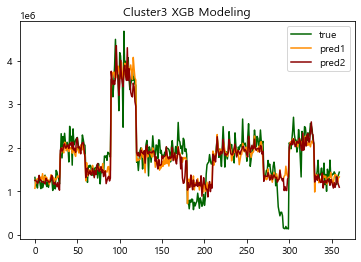

In [1874]:
# XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb3_2).plot(label='pred1',color='darkorange')
(pd.Series(pred_xgb3_1) +pd.Series(y1_plus)).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster3 XGB Modeling')
plt.show()

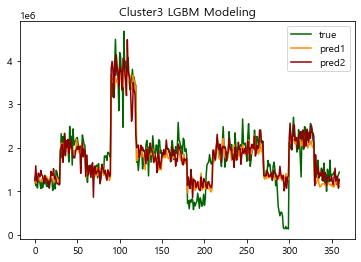

In [1875]:
# LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb3_2).plot(label='pred1',color='darkorange')
(pd.Series(pred_lgb3_1) +pd.Series(y1_plus)).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster3 LGBM Modeling')
plt.show()

In [1876]:
#예측값 앙상블
pred3=pd.Series(gmean([(pd.Series(pred_xgb3_1) +y1_plus),(pd.Series(pred_lgb3_1) +y1_plus),pred_xgb3_2,pred_lgb3_2])).fillna(0)

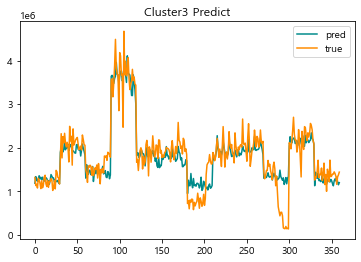

In [1877]:
#군집 3 최종예측
pd.Series(pred3).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster3 Predict')
plt.show()

In [1878]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred3)

239495.80153712706

In [1880]:
#음식물쓰레기 배출량 6월 예측값
sum(pred3)

647920708.902049

In [1882]:
#음식물쓰레기 6월 배출량
sum(y2_test)

658290000.0

**8월예측하기**

In [1885]:
august_pred3=pd.Series(gmean([august_xgb3_1+august1_plus,august_lgb3_1+august1_plus,august_xgb3_2,august_lgb3_2])).fillna(0)

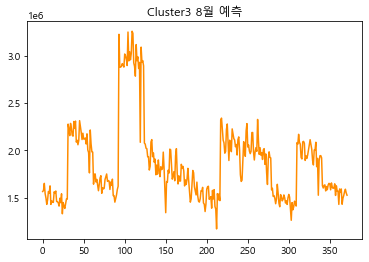

In [1886]:
august_pred3.plot(color='darkorange')
plt.title('Cluster3 8월 예측')
plt.show()

## Cluster4

In [1887]:
featureset4=pd.read_csv('features/군집4_feature_corona.csv')
featureset4=featureset4.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1888]:
X,y=create_features(featureset4,0,'em_g_jh')

In [1889]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1890]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1892]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1) 

In [1893]:
# XGB 차이예측
pred_xgb4_1, august_xgb4_1, xgb_clf4_1=model(BO_xgb1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -8.945e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -8.095e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -7.943e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -7.14e+05 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -8.575e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -7.233e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -9.263e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -8.153e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -7.99e+05 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -7.08e+05 |  3.353    |  0.3551   |  6.2

In [1894]:
# XGB 직접예측
pred_xgb4_2, august_xgb4_2, xgb_clf4_2=model(BO_xgb2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -8.361e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -8.016e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -8.084e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -7.609e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -8.217e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -7.671e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -7.882e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -7.413e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -7.598e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -7.337e+0 |  3.353    |  0.3551   |  6.2

In [1895]:
# LGBM 차이예측
pred_lgb4_1, august_lgb4_1, lgb_clf4_1=model(BO_lgbm1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -6.658e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -7.594e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -8.567e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -6.971e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -9.261e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -9.749e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -7.498e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1896]:
# LGBM 직접예측
pred_lgb4_2, august_lgb4_2, lgb_clf4_2=model(BO_lgbm2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -6.377e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -6.902e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -6.927e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -7.354e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -6.519e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -7.558e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -6.589e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

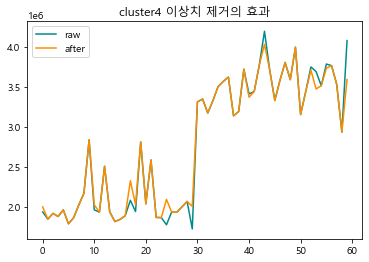

In [1897]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb4_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb4_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('cluster4 이상치 제거의 효과')
plt.show()

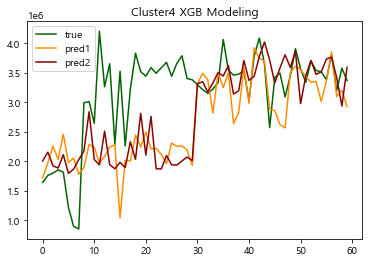

In [1898]:
# XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb4_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster4 XGB Modeling')
plt.show()

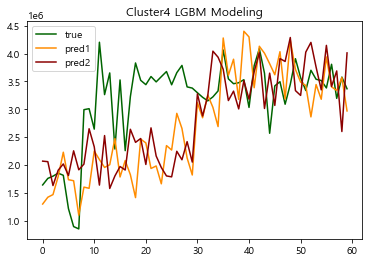

In [1899]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb4_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster4 LGBM Modeling')
plt.show()

In [1900]:
#이상치 제거
after_xgb4_1=(pd.DataFrame(pred_xgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb4_1=(pd.DataFrame(pred_lgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1902]:
#예측값 앙상블
pred4=pd.Series(gmean([after_xgb4_1,after_lgb4_1,pred_xgb4_2,pred_lgb4_2])).fillna(0)

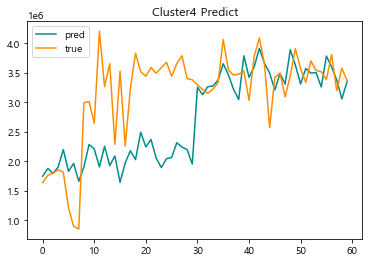

In [1903]:
#군집 4 최종예측
pd.Series(pred4).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster4 Predict')
plt.show()

In [1904]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred4)

628212.9243924727

In [1906]:
#음식물쓰레기 배출량 6월 예측값
sum(pred4)

164579181.58788508

In [1908]:
#음식물쓰레기 6월 배출량
sum(y2_test)

189445160.0

**8월예측하기**

In [1911]:
after_august_xgb4_1=(pd.DataFrame(august_xgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1912]:
after_august_lgb4_1=(pd.DataFrame(august_lgb4_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1913]:
august_pred4=pd.Series(gmean([after_august_xgb4_1,after_august_lgb4_1,august_xgb4_2,august_lgb4_2])).fillna(0)

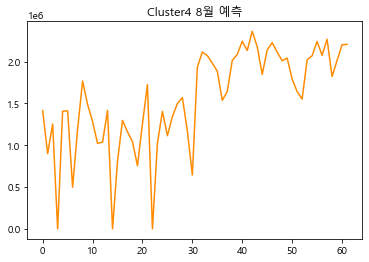

In [1914]:
august_pred4.plot(color='darkorange')
plt.title('Cluster4 8월 예측')
plt.show()

## Cluster5

In [1915]:
featureset5=pd.read_csv('features/군집5_feature_corona.csv')
featureset5=featureset5.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1916]:
X,y=create_features(featureset5,0,'em_g_jh')

In [1917]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1918]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1920]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1) 

In [1921]:
# XGB 차이예측
pred_xgb5_1, august_xgb5_1, xgb_clf5_1=model(BO_xgb1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -1.452e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -1.055e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -9.991e+0 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -8.694e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -1.412e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -8.697e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -1.512e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -1.204e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -1.103e+0 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -9.782e+0 |  3.353    |  0.3551   |  6.2

In [1922]:
# XGB 직접예측
pred_xgb5_2, august_xgb5_2, xgb_clf5_2=model(BO_xgb2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -1.142e+0 |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        | -8.826e+0 |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        | -8.73e+05 |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        | -8.774e+0 |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        | -1.338e+0 |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        | -8.262e+0 |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        | -1.329e+0 |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        | -7.944e+0 |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        | -8.23e+05 |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       | -7.244e+0 |  3.353    |  0.3551   |  6.2

In [1923]:
# LGBM 차이예측
pred_lgb5_1, august_lgb5_1, lgb_clf5_1=model(BO_lgbm1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -8e+05    |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -1.101e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -1.345e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -9.183e+0 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -1.665e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -1.529e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -1.27e+06 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1924]:
# LGBM 직접예측
pred_lgb5_2, august_lgb5_2, lgb_clf5_2=model(BO_lgbm2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -8.195e+0 |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -8.479e+0 |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -8.005e+0 |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -6.02e+05 |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -1.036e+0 |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -8.678e+0 |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -8.918e+0 |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

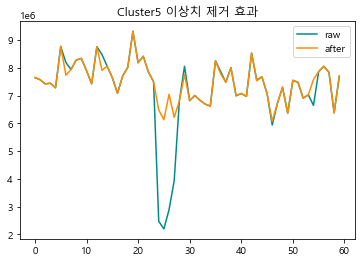

In [1925]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb5_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb5_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('Cluster5 이상치 제거 효과')
plt.show()

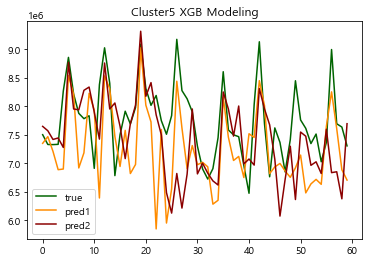

In [1926]:
# XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb5_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster5 XGB Modeling')
plt.show()

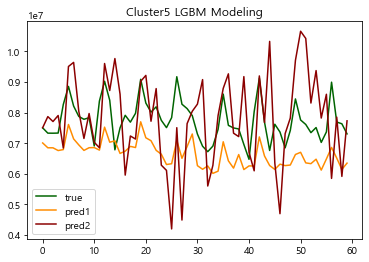

In [1927]:
# LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb5_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster5 LGBM Modeling')
plt.show()

In [1928]:
# 이상치 제거
after_xgb5_1=(pd.DataFrame(pred_xgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb5_1=(pd.DataFrame(pred_lgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1930]:
# 예측값 앙상블
pred5=pd.Series(gmean([after_xgb5_1,after_lgb5_1,pred_xgb5_2,pred_lgb5_2])).fillna(0)

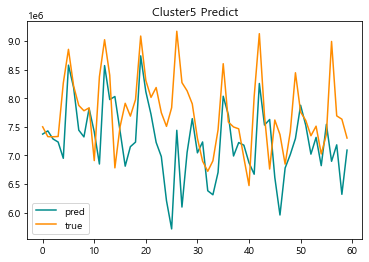

In [1931]:
# 군집5 최종예측
pd.Series(pred5).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true', color='darkorange')
plt.legend()
plt.title('Cluster5 Predict')
plt.show()

In [1932]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred5)

625999.4936144347

In [1934]:
# 음식물 쓰레기 배출량 6월 예측값
sum(pred5)

435117220.2789466

In [1936]:
#음식물 쓰레기 6월 배출량
sum(y2_test)

464492450.0

**8월예측하기**

In [1939]:
after_august_xgb5_1=(pd.DataFrame(august_xgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1940]:
after_august_lgb5_1=(pd.DataFrame(august_lgb5_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1941]:
august_pred5=pd.Series(gmean([after_august_xgb5_1,after_august_lgb5_1,august_xgb5_2,august_lgb5_2])).fillna(0)

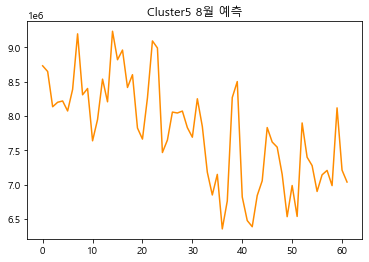

In [1942]:
august_pred5.plot(color='darkorange')
plt.title('Cluster5 8월 예측')
plt.show()

## Cluster6

In [1943]:
featureset6=pd.read_csv('features/군집6_feature_corona.csv')
featureset6=featureset6.sort_values(['emd_nm_jh','base_date_jh']).reset_index(drop=True)

In [1944]:
X,y=create_features(featureset6,0,'em_g_jh')

In [1945]:
X1,X1_train,X1_test,july1,august1,y1_train,y1_test,y1_plus,july1_plus,august1_plus=train_test1(X,y)

In [1946]:
X2,X2_train,X2_test,july2,august2,y2_train,y2_test,=train_test2(X,y)

In [1948]:
BO_xgb1 = BayesianOptimization(f = xgb_opt1, pbounds = xgb_pbounds, random_state=0)
BO_xgb2 = BayesianOptimization(f = xgb_opt2, pbounds = xgb_pbounds, random_state=0)

BO_lgbm1 = BayesianOptimization(f = lgbm_opt1, pbounds = lgbm_pbounds, random_state=1) 
BO_lgbm2 = BayesianOptimization(f = lgbm_opt2, pbounds = lgbm_pbounds, random_state=1) 

In [1949]:
# XGB 차이예측
pred_xgb6_1, august_xgb6_1, xgb_clf6_1=model(BO_xgb1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.7305   |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        |  0.772    |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        |  0.6734   |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        |  0.7779   |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        |  0.7434   |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        |  0.4483   |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        |  0.6478   |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        |  0.7485   |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        |  0.74     |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       |  0.7631   |  3.353    |  0.3551   |  6.2

In [1950]:
# XGB 직접예측
pred_xgb6_2, august_xgb6_2, xgb_clf6_2=model(BO_xgb2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.8018   |  2.744    |  1.087    |  11.03    |  77.24    |  0.8635   |
|  2        |  0.7492   |  3.229    |  0.6845   |  13.92    |  98.18    |  0.8575   |
|  3        |  0.8439   |  3.959    |  0.8169   |  10.68    |  96.28    |  0.8107   |
|  4        |  0.7773   |  0.4356   |  0.07932  |  13.33    |  88.91    |  0.9305   |
|  5        |  0.8061   |  4.893    |  1.209    |  9.615    |  89.03    |  0.8177   |
|  6        |  0.7696   |  3.2      |  0.2579   |  14.45    |  76.09    |  0.8622   |
|  7        |  0.7817   |  1.323    |  1.173    |  9.562    |  78.42    |  0.8028   |
|  8        |  0.7858   |  3.088    |  0.9375   |  11.17    |  97.19    |  0.9023   |
|  9        |  0.7845   |  1.798    |  0.6837   |  11.98    |  53.01    |  0.9      |
|  10       |  0.7557   |  3.353    |  0.3551   |  6.2

In [1951]:
# LGBM 차이예측
pred_lgb6_1, august_lgb6_1, lgb_clf6_1=model(BO_lgbm1,X1_train,y1_train,X1_test,august1)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.4525   |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -0.3943   |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -1.363    |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -0.8753   |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -1.145    |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -0.7745   |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -1.793    |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [1952]:
# LGBM 직접예측
pred_lgb6_2, august_lgb6_2, lgb_clf6_2=model(BO_lgbm2,X2_train,y2_train,X2_test,august2)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.2401   |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        | -0.3356   |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        | -0.8996   |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        | -0.7028   |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        | -0.444    |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        | -0.4319   |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        | -0.4889   |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

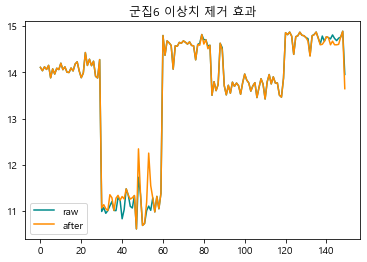

In [1953]:
#이상치 제거를 통해 과도하게 낮게 예측되는 값에 대해서 보정을 한다.
pd.Series(pred_xgb6_1 +y1_plus).plot(label='raw',color='darkcyan')
(pd.Series(pred_xgb6_1) +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='after',color='darkorange')
plt.legend()
plt.title('군집6 이상치 제거 효과')
plt.show()

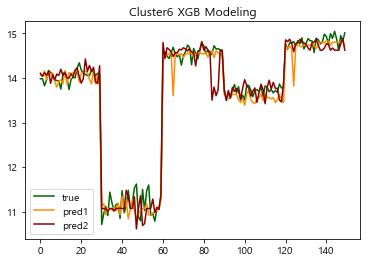

In [1954]:
#XGB 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_xgb6_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_xgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster6 XGB Modeling')
plt.show()

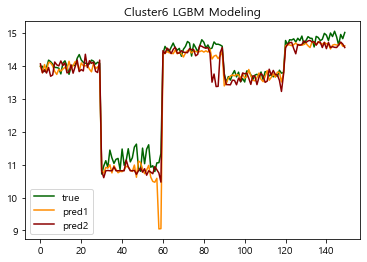

In [1955]:
#LGBM 예측 시각화
pd.Series(y1_test+y1_plus).plot(label='true',color='darkgreen')
pd.Series(pred_lgb6_2).plot(label='pred1',color='darkorange')
(pd.DataFrame(pred_lgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0]).plot(label='pred2',color='darkred')
plt.legend()
plt.title('Cluster6 LGBM Modeling')
plt.show()

In [1956]:
#이상치제거
after_xgb6_1=(pd.DataFrame(pred_xgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])
after_lgb6_1=(pd.DataFrame(pred_lgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(y1_plus).apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)[0])

In [1958]:
#예측값 앙상블
pred6=pd.Series(gmean([after_xgb6_1,after_lgb6_1,pred_xgb6_2,pred_lgb6_2])).fillna(0)

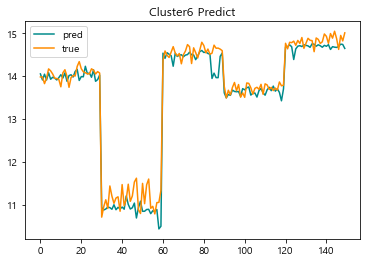

In [1959]:
#군집 6 최종 예측
pd.Series(pred6).plot(label='pred',color='darkcyan')
(y2_test.reset_index(drop=True)).plot(label='true',color='darkorange')
plt.legend()
plt.title('Cluster6 Predict')
plt.show()

In [1960]:
#예측값과 실제값 MAE
mean_absolute_error(y1_test+y1_plus,pred6)

0.17778467508846543

In [1962]:
#음식물쓰레기 배출량 6월 예측값
sum(pred6)

2029.2825103473972

In [1964]:
#음식물쓰레기 6월 배출량
sum(y2_test)

2048.5049295181952

**8월예측하기**

In [1967]:
after_august_xgb6_1=(pd.DataFrame(august_xgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1968]:
after_august_lgb6_1=(pd.DataFrame(august_lgb6_1).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0] +pd.DataFrame(august1_plus).apply(lambda x: x.clip(x.quantile(.1), x.quantile(.9)), axis=0)[0])

In [1969]:
august_pred6=pd.Series(gmean([after_august_xgb6_1,after_august_lgb6_1,august_xgb6_2,august_lgb6_2])).fillna(0)

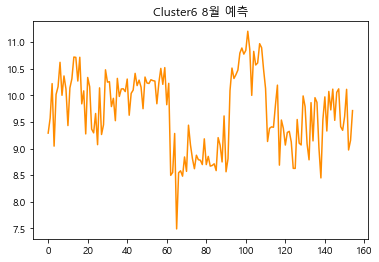

In [1970]:
august_pred6.plot(color='darkorange')
plt.title('Cluster6 8월 예측')
plt.show()

### 최종 8월

In [1971]:
august_predict=pd.DataFrame({'ml0':august_pred0,'ml1':august_pred1,'ml2':august_pred2,'ml3':august_pred3,'ml4':august_pred4,'ml5':august_pred5,'ml6':august_pred6})
august_predict.to_csv('predict/ml_08_predict.csv')